In [24]:
import networkx as nx
import numpy as np
import torch
from model import CaT
import inference
import pandas as pd
import matplotlib.pyplot as plt
from datasets import get_full_ordering, reorder_dag
import utils

shuffling = 0
seed = 1
standardize = 0
sample_size = 100000
batch_size = 300
max_iters = 50000
eval_interval = 1000
eval_iters = 100
validation_fraction = 0.1
np.random.seed(seed=seed)
torch.manual_seed(seed)
device = 'cuda'
dropout_rate = 0.0
learning_rate = 1e-3
ff_n_embed = 2
num_heads = 1
n_layers = 1
head_size = 2
d = 1

x_shift = 0
b_shift = 0
y_shift = 0  # makes no difference
# def generate_data(N, d=3):
#     DAGnx = nx.DiGraph()
#     
#     Ux = np.random.randn(N,d)
#     X = (Ux > 0).astype(float)
# 
#     
#     Ub = np.random.randn(N,d)
#     B =  Ub
#     
#     Uc = np.random.randn(N,d)
#     C =  Uc
#     
#     Uy = np.random.randn(N,d)
#     Y = 0.3 * X + 0.6 * B + 1.2 * C +  0.01 * Uy
# 
#     Y0 = 0.3 * 0 + 0.6 * B + 1.2 * C +  0.01 * Uy
#     Y1 =  0.3 * 1 + 0.6 * B + 1.2 * C + 0.01 * Uy
# 
#     all_data_dict = {'X': X, 'B': B, 'C': C, 'Y': Y}
# 
#     # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
#     var_types = {'X': 'cont', 'B': 'cont', 'C': 'cont', 'Y': 'cont'}
# 
#     DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y'), ('C', 'Y')])
#     DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
#     var_names = list(DAGnx.nodes())  # topologically ordered list of variables
#     all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
#     causal_ordering = get_full_ordering(DAGnx)
#     ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))
# 
#     return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1


def generate_data(N, x_shift=0, y_shift=0, b_shift=0, d=1):
    DAGnx = nx.DiGraph()
    
    Ux = np.random.randn(N,d)
    X =  x_shift + Ux

    Ub = np.random.randn(N,d)
    B =  b_shift +  Ub
    
    Uc = np.random.randn(N,d)
    C =  Uc
    
    Uy = np.random.randn(N,d)
    Y =  y_shift + 0.3 * X - 0.3 * B + 0.01 * Uy

    Y0 =  y_shift + 0.3 * 0 - 0.3 * B +  0.01 * Uy
    Y1 =  y_shift + 0.3 * 1 - 0.3 * B + 0.01 * Uy

    all_data_dict = {'X': X, 'B':B, 'Y': Y}

    # types can be 'cat' (categorical) 'cont' (continuous) or 'bin' (binary)
    var_types = {'X': 'cont', 'B': 'cont', 'Y': 'cont'}

    DAGnx.add_edges_from([('X', 'Y'), ('B', 'Y',)])
    DAGnx = reorder_dag(dag=DAGnx)  # topologically sorted dag
    var_names = list(DAGnx.nodes())  # topologically ordered list of variables
    all_data = np.stack([all_data_dict[key] for key in var_names], axis=1)
    causal_ordering = get_full_ordering(DAGnx)
    ordered_var_types = dict(sorted(var_types.items(), key=lambda item: causal_ordering[item[0]]))

    return all_data, DAGnx, var_names, causal_ordering, ordered_var_types, Y0, Y1


def get_batch(train_data, val_data, split, device, batch_size):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(0, len(data), (batch_size,))
    x = data[ix]
    return x.to(device)

def input_output_sensitivity_matrix(input, model, epsilon=100.0, full=True):
    model.eval()
    input = input.detach().clone() 
    
    if full:
        original_output, _, _ = model(X=input, targets=input, shuffling=False)
    else:
        original_output = model(X=input)
    
    sensitivity_matrix = torch.zeros((input.size(1), original_output.size(1)))

    for i in range(input.size(1)): 
        perturbed_input = input.clone()
        perturbed_input[0, i] += epsilon  
        
        if full:
            perturbed_output, _, _ = model(X=perturbed_input, targets=perturbed_input, shuffling=False)
        else:
            perturbed_output = model(X=perturbed_input)
            
        output_difference = perturbed_output - original_output

        sensitivity_matrix[i, :] =  torch.abs(output_difference.view(-1))
    
    return sensitivity_matrix

## Exogenous Example

ATE: [0.3]
step 0 of 50000: train_loss 0.2538, val loss 0.2540
step 1000 of 50000: train_loss 0.1788, val loss 0.1835
step 2000 of 50000: train_loss 0.1776, val loss 0.1840
step 3000 of 50000: train_loss 0.1799, val loss 0.1858
step 4000 of 50000: train_loss 0.1805, val loss 0.1837
step 5000 of 50000: train_loss 0.1793, val loss 0.1849
step 6000 of 50000: train_loss 0.1809, val loss 0.1823
step 7000 of 50000: train_loss 0.1821, val loss 0.1865
step 8000 of 50000: train_loss 0.1825, val loss 0.1828
step 9000 of 50000: train_loss 0.1782, val loss 0.1868
step 10000 of 50000: train_loss 0.1800, val loss 0.1840
step 11000 of 50000: train_loss 0.1796, val loss 0.1857
step 12000 of 50000: train_loss 0.1797, val loss 0.1841
step 13000 of 50000: train_loss 0.1815, val loss 0.1869
step 14000 of 50000: train_loss 0.1790, val loss 0.1821
step 15000 of 50000: train_loss 0.1786, val loss 0.1840
step 16000 of 50000: train_loss 0.1803, val loss 0.1839
step 17000 of 50000: train_loss 0.1790, val loss 0

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


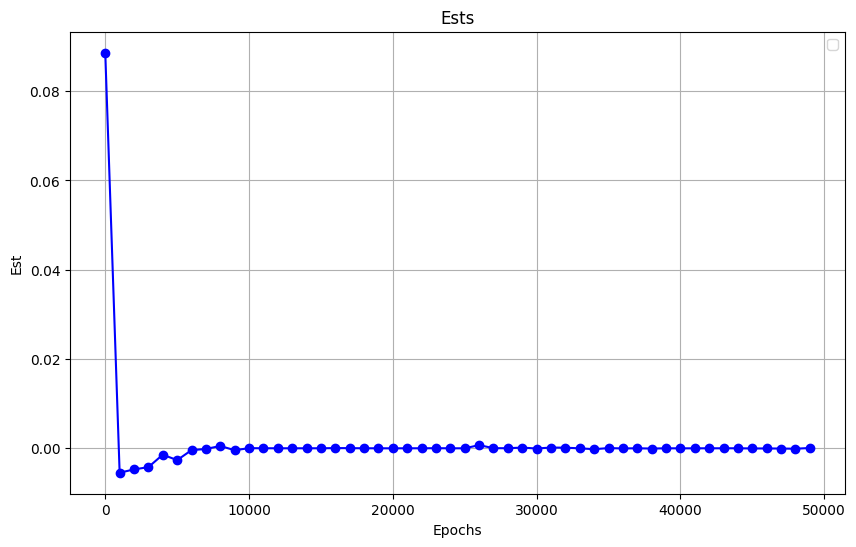

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


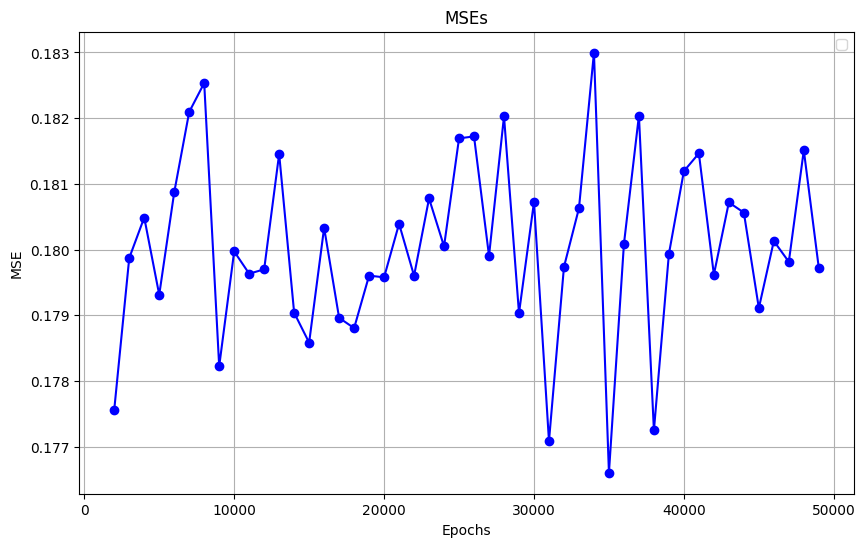

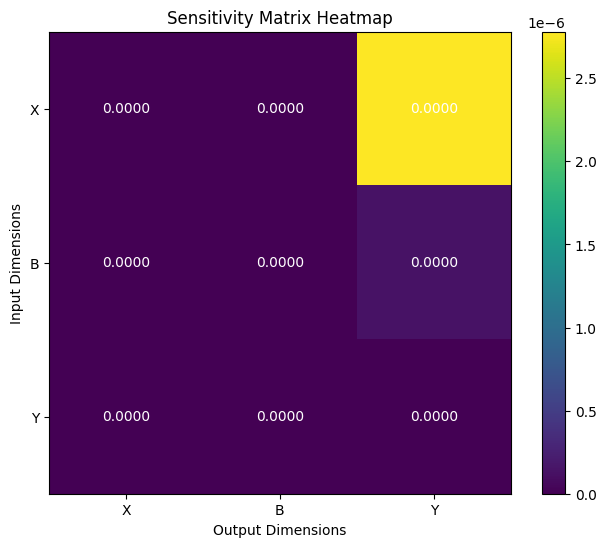

ATE: [0.3] est ATE: -4.6251000557094814e-06
0.2
step 0 of 50000: train_loss 0.1782, val loss 0.1835
step 1000 of 50000: train_loss 0.1739, val loss 0.1791
step 2000 of 50000: train_loss 0.1785, val loss 0.1746
step 3000 of 50000: train_loss 0.1755, val loss 0.1803
step 4000 of 50000: train_loss 0.1782, val loss 0.1782
step 5000 of 50000: train_loss 0.1795, val loss 0.1777
step 6000 of 50000: train_loss 0.1766, val loss 0.1790
step 7000 of 50000: train_loss 0.1739, val loss 0.1780
step 8000 of 50000: train_loss 0.1799, val loss 0.1802
step 9000 of 50000: train_loss 0.1751, val loss 0.1775
step 10000 of 50000: train_loss 0.1774, val loss 0.1768
step 11000 of 50000: train_loss 0.1757, val loss 0.1777
step 12000 of 50000: train_loss 0.1767, val loss 0.1780
step 13000 of 50000: train_loss 0.1772, val loss 0.1767
step 14000 of 50000: train_loss 0.1763, val loss 0.1789
step 15000 of 50000: train_loss 0.1784, val loss 0.1788
step 16000 of 50000: train_loss 0.1795, val loss 0.1771
step 17000 of

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


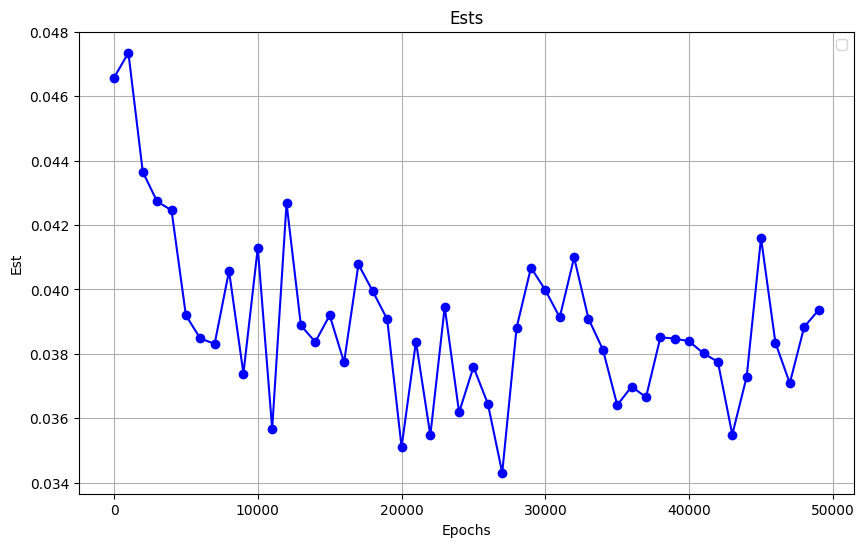

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


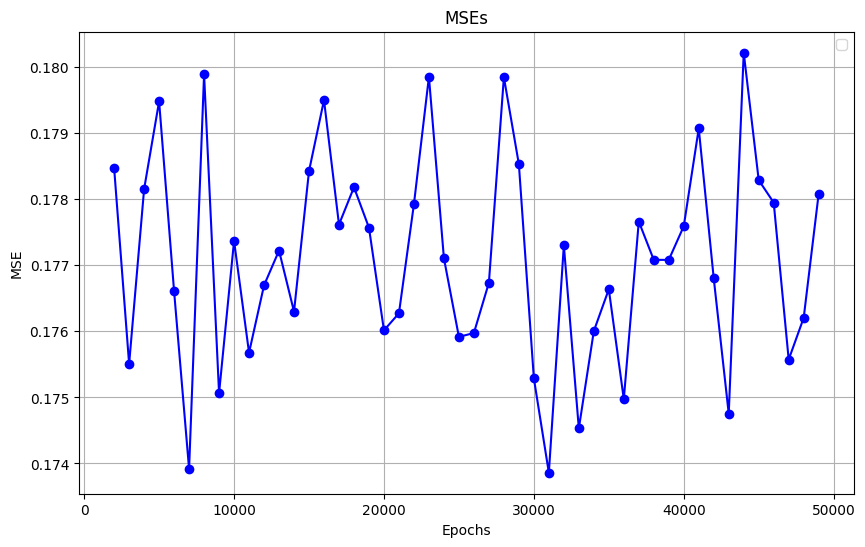

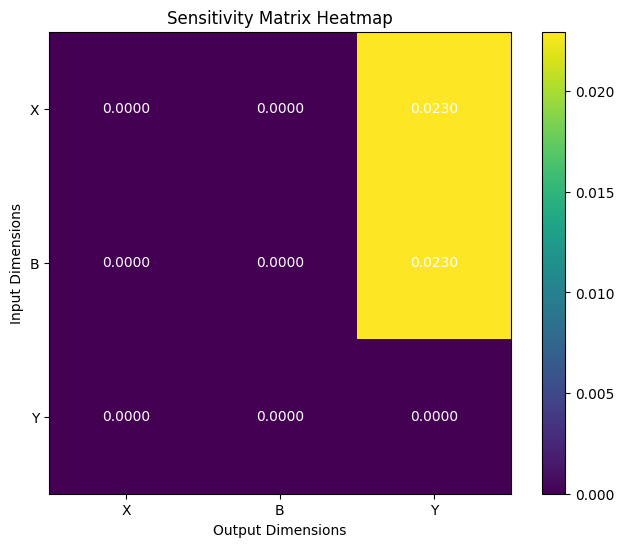

ATE: [0.3] est ATE: 0.0410725240598293
0.4
step 0 of 50000: train_loss 0.2045, val loss 0.2046
step 1000 of 50000: train_loss 0.1693, val loss 0.1673
step 2000 of 50000: train_loss 0.1694, val loss 0.1672
step 3000 of 50000: train_loss 0.1674, val loss 0.1682
step 4000 of 50000: train_loss 0.1707, val loss 0.1679
step 5000 of 50000: train_loss 0.1681, val loss 0.1654
step 6000 of 50000: train_loss 0.1693, val loss 0.1677
step 7000 of 50000: train_loss 0.1702, val loss 0.1659
step 8000 of 50000: train_loss 0.1687, val loss 0.1668
step 9000 of 50000: train_loss 0.1703, val loss 0.1670
step 10000 of 50000: train_loss 0.1686, val loss 0.1681
step 11000 of 50000: train_loss 0.1705, val loss 0.1685
step 12000 of 50000: train_loss 0.1704, val loss 0.1724
step 13000 of 50000: train_loss 0.1700, val loss 0.1652
step 14000 of 50000: train_loss 0.1711, val loss 0.1655
step 15000 of 50000: train_loss 0.1709, val loss 0.1672
step 16000 of 50000: train_loss 0.1693, val loss 0.1664
step 17000 of 5000

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


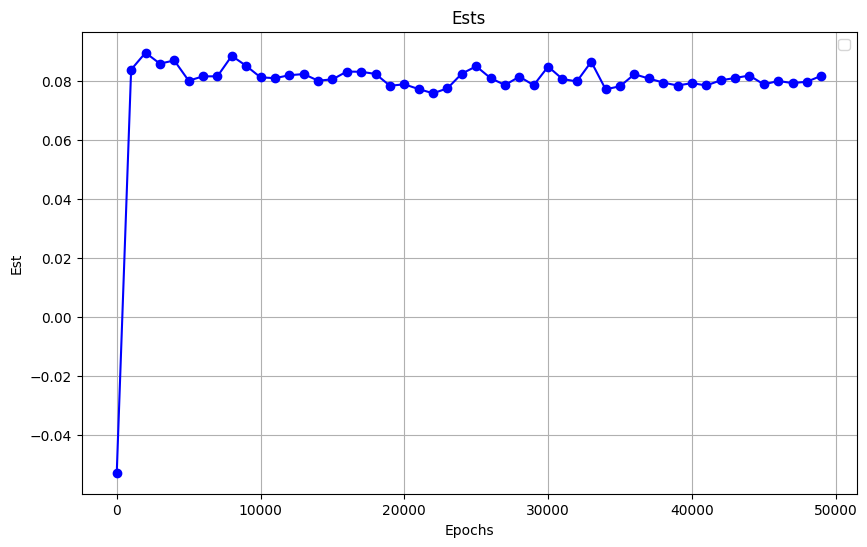

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


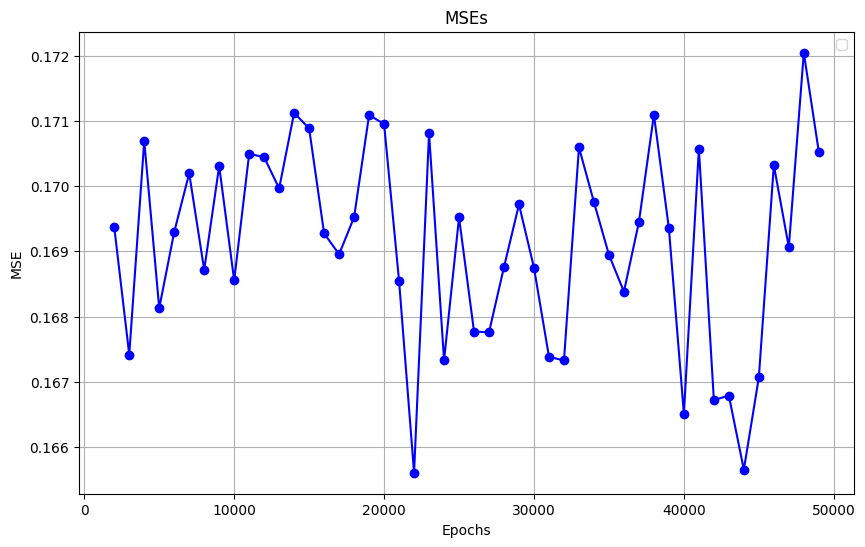

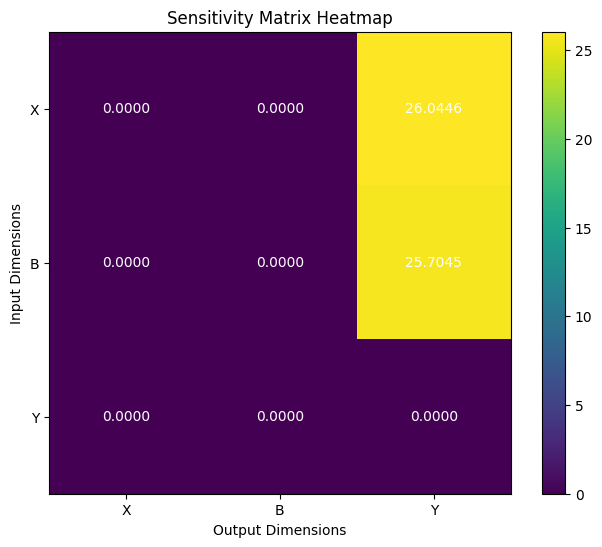

ATE: [0.3] est ATE: 0.08143004749912769
0.6000000000000001
step 0 of 50000: train_loss 0.2188, val loss 0.2128
step 1000 of 50000: train_loss 0.1517, val loss 0.1564
step 2000 of 50000: train_loss 0.1537, val loss 0.1562
step 3000 of 50000: train_loss 0.1546, val loss 0.1547
step 4000 of 50000: train_loss 0.1516, val loss 0.1542
step 5000 of 50000: train_loss 0.1556, val loss 0.1543
step 6000 of 50000: train_loss 0.1534, val loss 0.1529
step 7000 of 50000: train_loss 0.1528, val loss 0.1563
step 8000 of 50000: train_loss 0.1533, val loss 0.1564
step 9000 of 50000: train_loss 0.1507, val loss 0.1536
step 10000 of 50000: train_loss 0.1513, val loss 0.1505
step 11000 of 50000: train_loss 0.1534, val loss 0.1534
step 12000 of 50000: train_loss 0.1532, val loss 0.1520
step 13000 of 50000: train_loss 0.1537, val loss 0.1552
step 14000 of 50000: train_loss 0.1512, val loss 0.1548
step 15000 of 50000: train_loss 0.1545, val loss 0.1501
step 16000 of 50000: train_loss 0.1517, val loss 0.1562
st

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


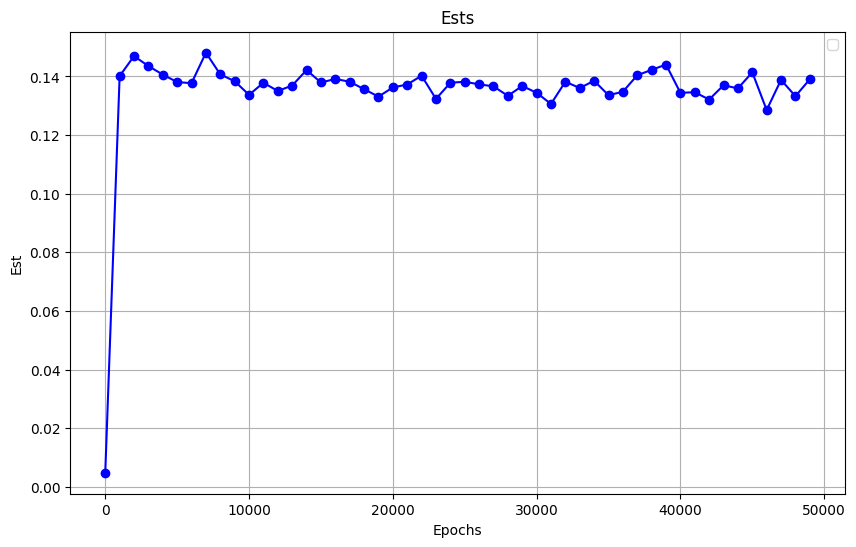

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


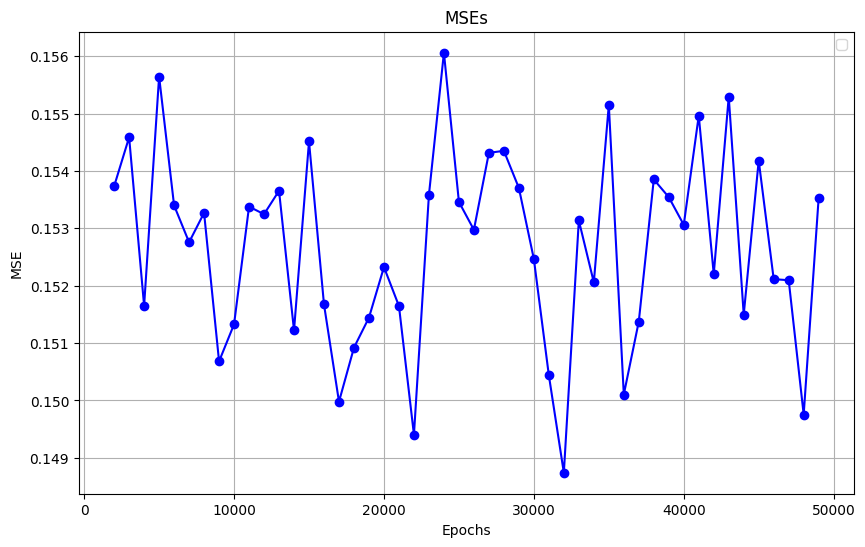

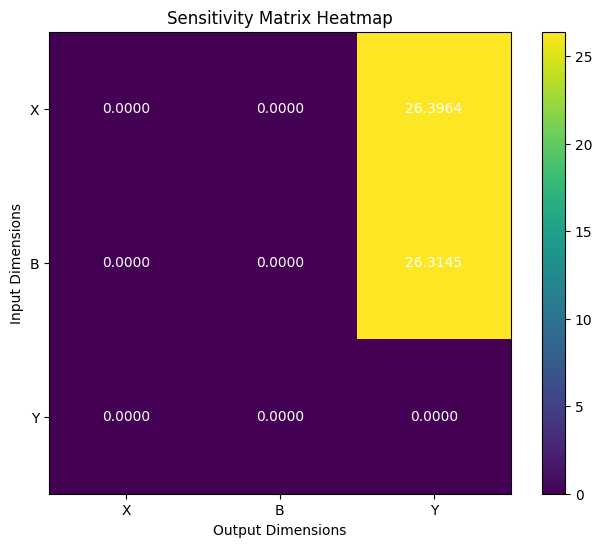

ATE: [0.3] est ATE: 0.1330797272871621
0.8
step 0 of 50000: train_loss 0.2699, val loss 0.2706
step 1000 of 50000: train_loss 0.1427, val loss 0.1452
step 2000 of 50000: train_loss 0.1340, val loss 0.1371
step 3000 of 50000: train_loss 0.1369, val loss 0.1344
step 4000 of 50000: train_loss 0.1345, val loss 0.1361
step 5000 of 50000: train_loss 0.1376, val loss 0.1358
step 6000 of 50000: train_loss 0.1355, val loss 0.1392
step 7000 of 50000: train_loss 0.1387, val loss 0.1345
step 8000 of 50000: train_loss 0.1391, val loss 0.1344
step 9000 of 50000: train_loss 0.1372, val loss 0.1345
step 10000 of 50000: train_loss 0.1383, val loss 0.1360
step 11000 of 50000: train_loss 0.1363, val loss 0.1372
step 12000 of 50000: train_loss 0.1376, val loss 0.1356
step 13000 of 50000: train_loss 0.1398, val loss 0.1376
step 14000 of 50000: train_loss 0.1374, val loss 0.1338
step 15000 of 50000: train_loss 0.1385, val loss 0.1342
step 16000 of 50000: train_loss 0.1393, val loss 0.1367
step 17000 of 5000

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


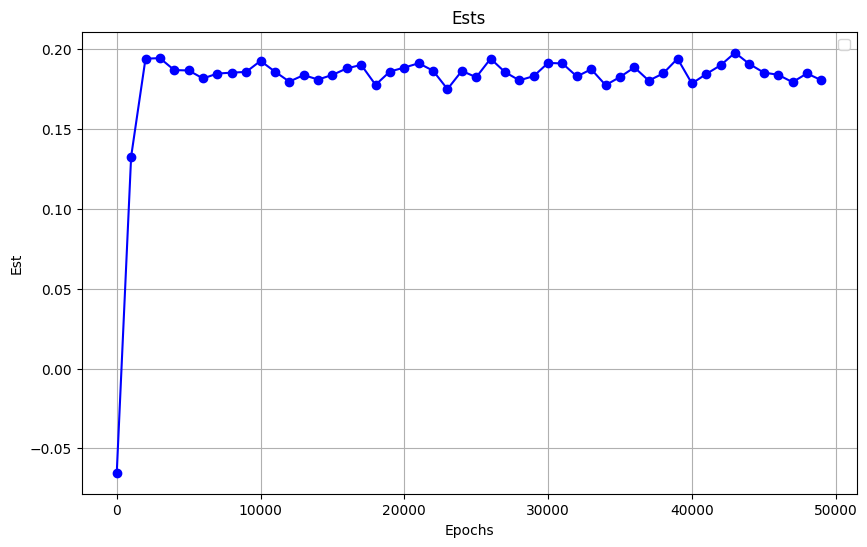

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


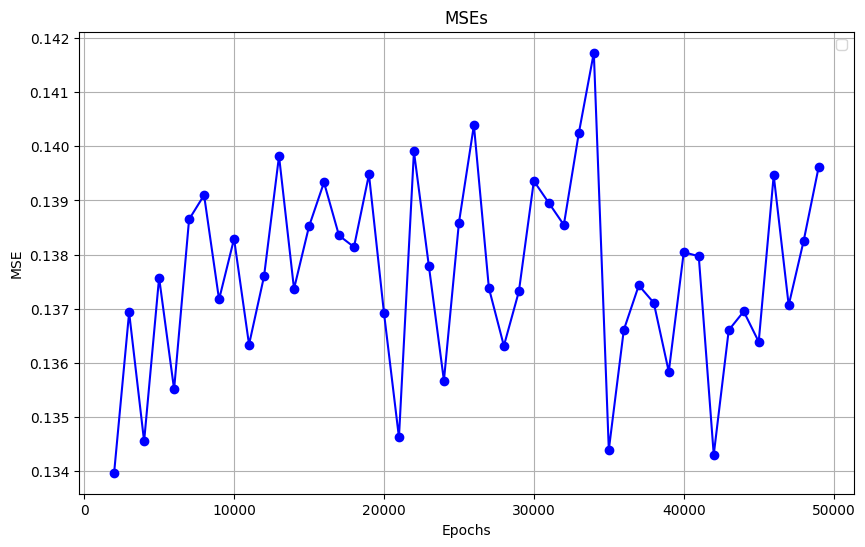

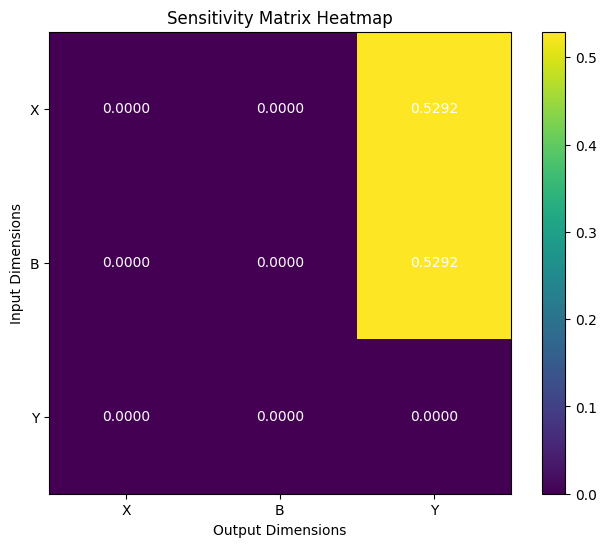

ATE: [0.3] est ATE: 0.1853175171256624
1.0
step 0 of 50000: train_loss 0.3512, val loss 0.3505
step 1000 of 50000: train_loss 0.1546, val loss 0.1549
step 2000 of 50000: train_loss 0.1364, val loss 0.1389
step 3000 of 50000: train_loss 0.1202, val loss 0.1196
step 4000 of 50000: train_loss 0.1178, val loss 0.1220
step 5000 of 50000: train_loss 0.1198, val loss 0.1238
step 6000 of 50000: train_loss 0.1190, val loss 0.1191
step 7000 of 50000: train_loss 0.1173, val loss 0.1209
step 8000 of 50000: train_loss 0.1183, val loss 0.1195
step 9000 of 50000: train_loss 0.1188, val loss 0.1205
step 10000 of 50000: train_loss 0.1161, val loss 0.1195
step 11000 of 50000: train_loss 0.1191, val loss 0.1171
step 12000 of 50000: train_loss 0.1191, val loss 0.1176
step 13000 of 50000: train_loss 0.1195, val loss 0.1168
step 14000 of 50000: train_loss 0.1192, val loss 0.1152
step 15000 of 50000: train_loss 0.1170, val loss 0.1196
step 16000 of 50000: train_loss 0.1219, val loss 0.1186
step 17000 of 5000

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


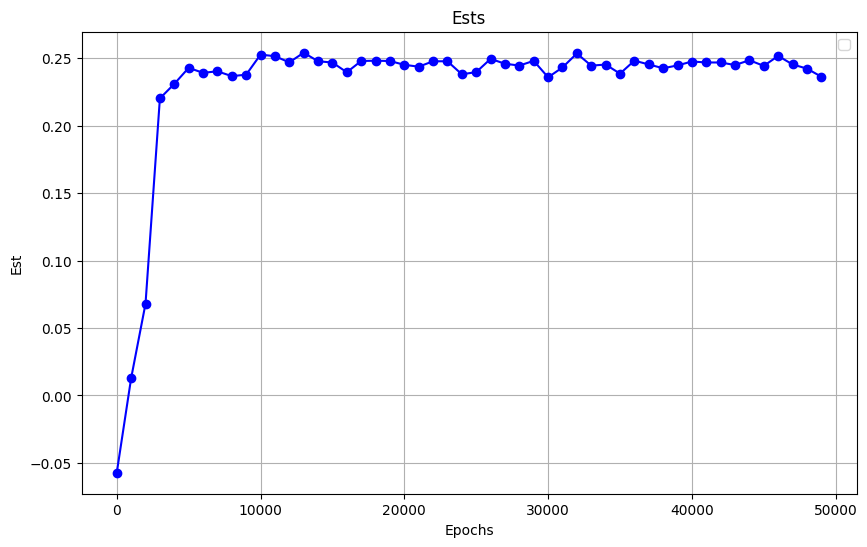

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


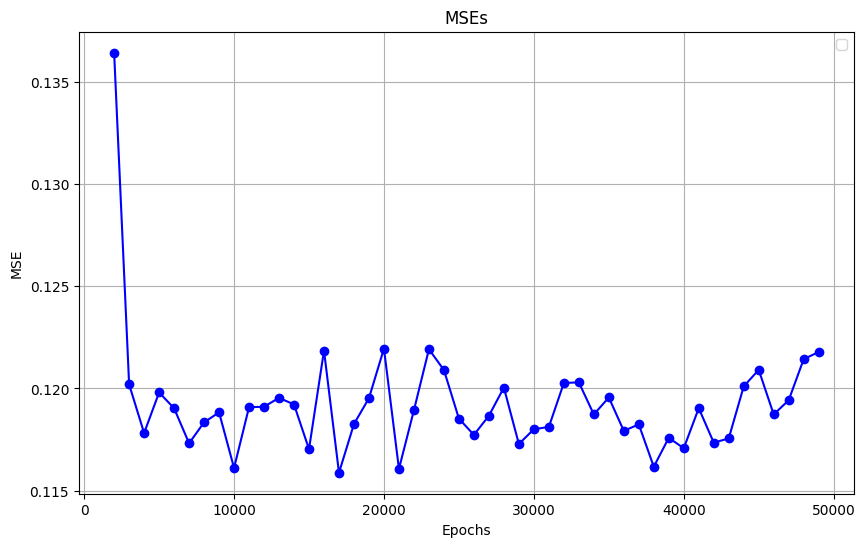

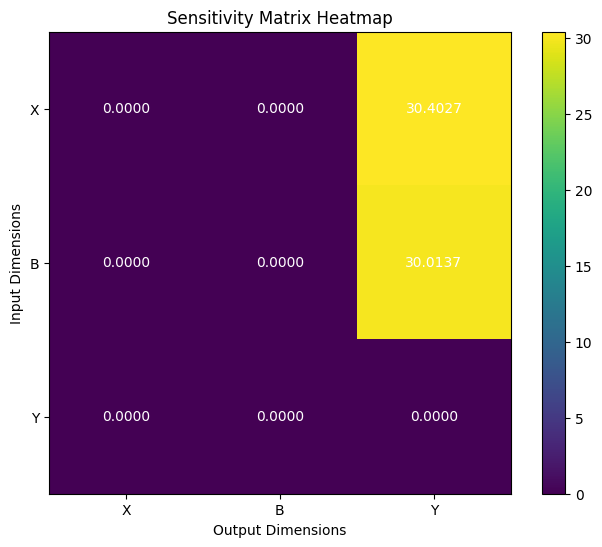

ATE: [0.3] est ATE: 0.2368140658453852
1.2
step 0 of 50000: train_loss 0.2108, val loss 0.2162
step 1000 of 50000: train_loss 0.1015, val loss 0.1045
step 2000 of 50000: train_loss 0.1039, val loss 0.1040
step 3000 of 50000: train_loss 0.1023, val loss 0.1056
step 4000 of 50000: train_loss 0.1038, val loss 0.1029
step 5000 of 50000: train_loss 0.1016, val loss 0.1033
step 6000 of 50000: train_loss 0.1046, val loss 0.1037
step 7000 of 50000: train_loss 0.1002, val loss 0.1030
step 8000 of 50000: train_loss 0.0996, val loss 0.1035
step 9000 of 50000: train_loss 0.1014, val loss 0.1026
step 10000 of 50000: train_loss 0.0985, val loss 0.1059
step 11000 of 50000: train_loss 0.1012, val loss 0.1047
step 12000 of 50000: train_loss 0.1036, val loss 0.1032
step 13000 of 50000: train_loss 0.1034, val loss 0.1030
step 14000 of 50000: train_loss 0.1029, val loss 0.1048
step 15000 of 50000: train_loss 0.1001, val loss 0.1035
step 16000 of 50000: train_loss 0.1029, val loss 0.1042
step 17000 of 5000

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


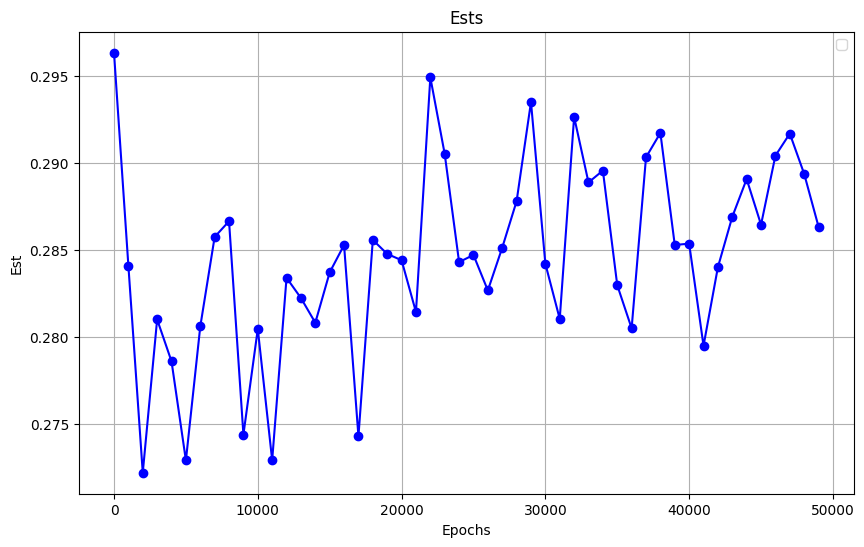

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


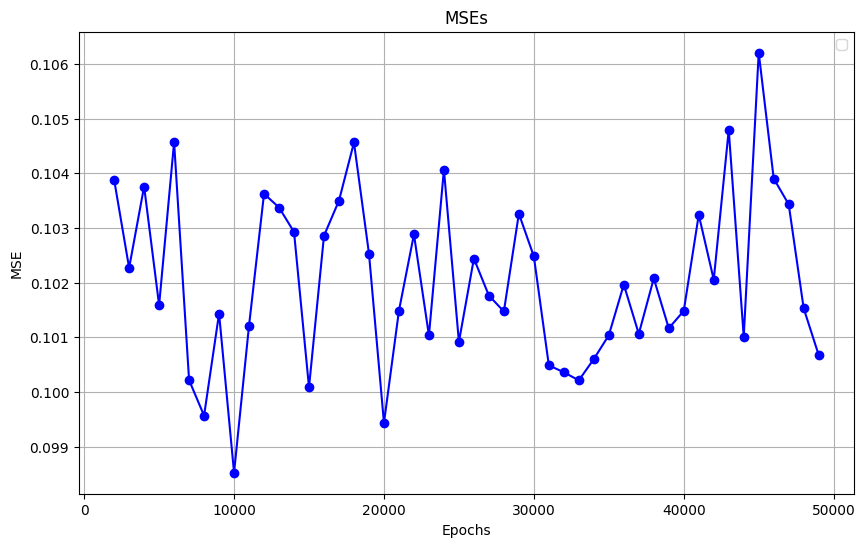

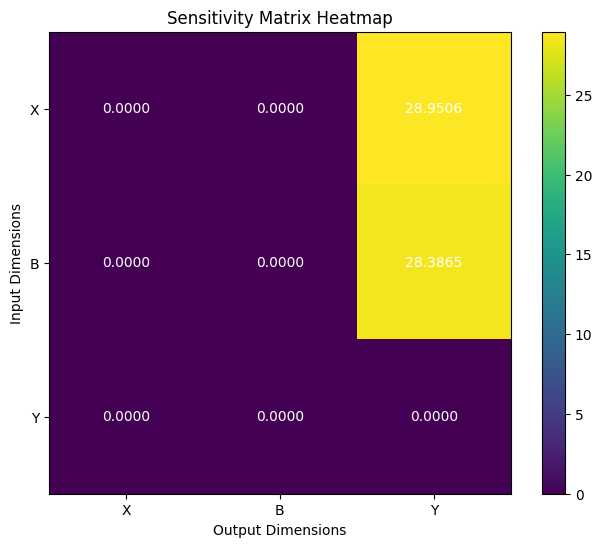

ATE: [0.3] est ATE: 0.29177643870413306
1.4
step 0 of 50000: train_loss 0.3569, val loss 0.3597
step 1000 of 50000: train_loss 0.1522, val loss 0.1471
step 2000 of 50000: train_loss 0.0932, val loss 0.0870
step 3000 of 50000: train_loss 0.0902, val loss 0.0818
step 4000 of 50000: train_loss 0.0893, val loss 0.0824
step 5000 of 50000: train_loss 0.0887, val loss 0.0801
step 6000 of 50000: train_loss 0.0865, val loss 0.0807
step 7000 of 50000: train_loss 0.0864, val loss 0.0797
step 8000 of 50000: train_loss 0.0843, val loss 0.0813
step 9000 of 50000: train_loss 0.0889, val loss 0.0790
step 10000 of 50000: train_loss 0.0863, val loss 0.0797
step 11000 of 50000: train_loss 0.0864, val loss 0.0813
step 12000 of 50000: train_loss 0.0841, val loss 0.0805
step 13000 of 50000: train_loss 0.0846, val loss 0.0789
step 14000 of 50000: train_loss 0.0884, val loss 0.0811
step 15000 of 50000: train_loss 0.0842, val loss 0.0813
step 16000 of 50000: train_loss 0.0869, val loss 0.0805
step 17000 of 500

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


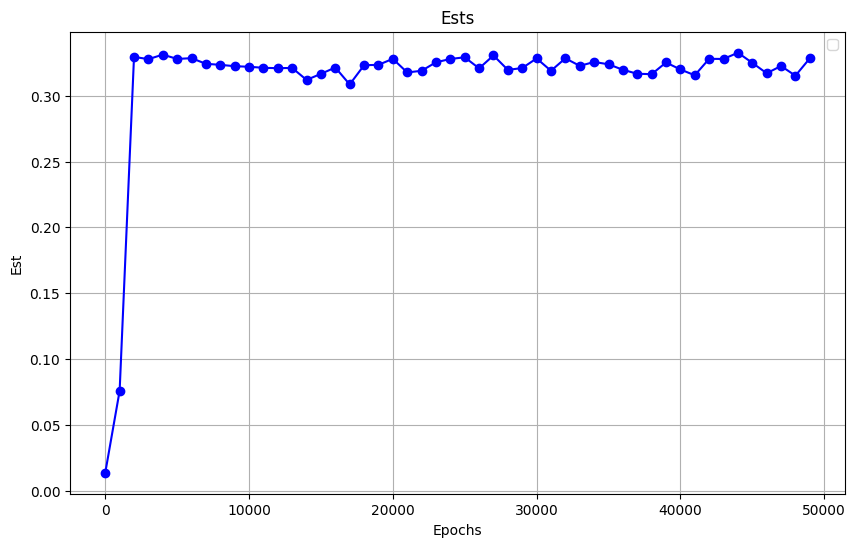

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


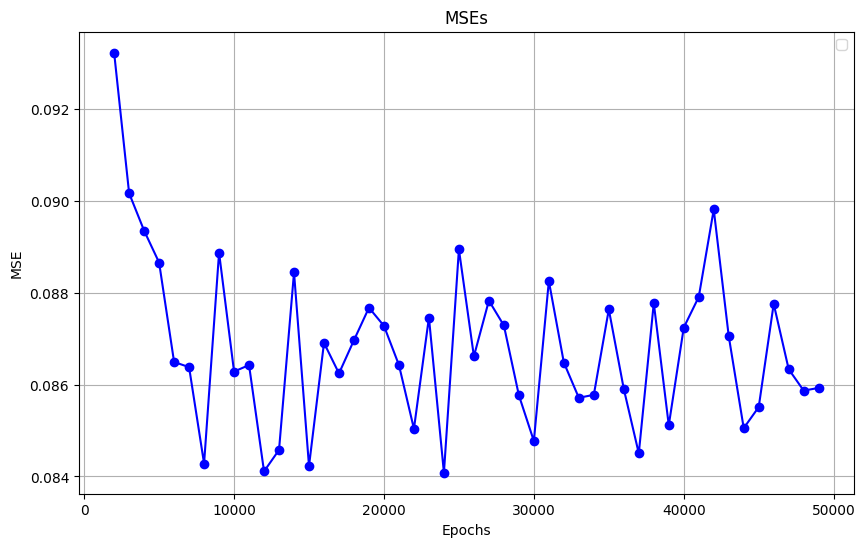

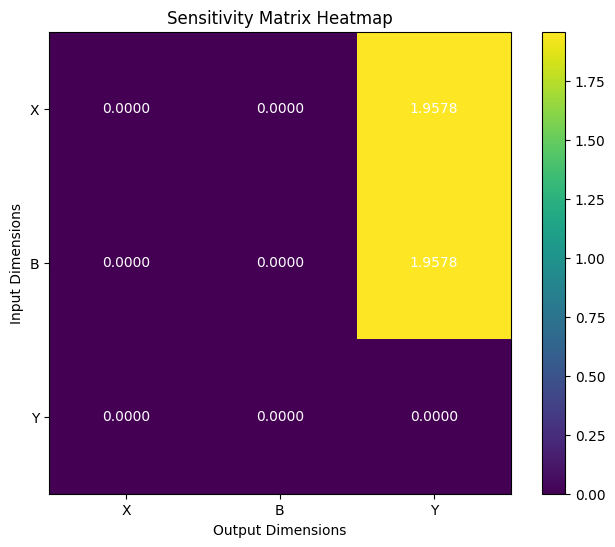

ATE: [0.3] est ATE: 0.3209540107204765
1.5999999999999999
step 0 of 50000: train_loss 0.1021, val loss 0.1015
step 1000 of 50000: train_loss 0.0788, val loss 0.0790
step 2000 of 50000: train_loss 0.0733, val loss 0.0744
step 3000 of 50000: train_loss 0.0724, val loss 0.0757
step 4000 of 50000: train_loss 0.0746, val loss 0.0736
step 5000 of 50000: train_loss 0.0698, val loss 0.0733
step 6000 of 50000: train_loss 0.0706, val loss 0.0730
step 7000 of 50000: train_loss 0.0734, val loss 0.0744
step 8000 of 50000: train_loss 0.0717, val loss 0.0733
step 9000 of 50000: train_loss 0.0710, val loss 0.0757
step 10000 of 50000: train_loss 0.0714, val loss 0.0704
step 11000 of 50000: train_loss 0.0709, val loss 0.0718
step 12000 of 50000: train_loss 0.0718, val loss 0.0725
step 13000 of 50000: train_loss 0.0711, val loss 0.0733
step 14000 of 50000: train_loss 0.0699, val loss 0.0737
step 15000 of 50000: train_loss 0.0709, val loss 0.0719
step 16000 of 50000: train_loss 0.0699, val loss 0.0730
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


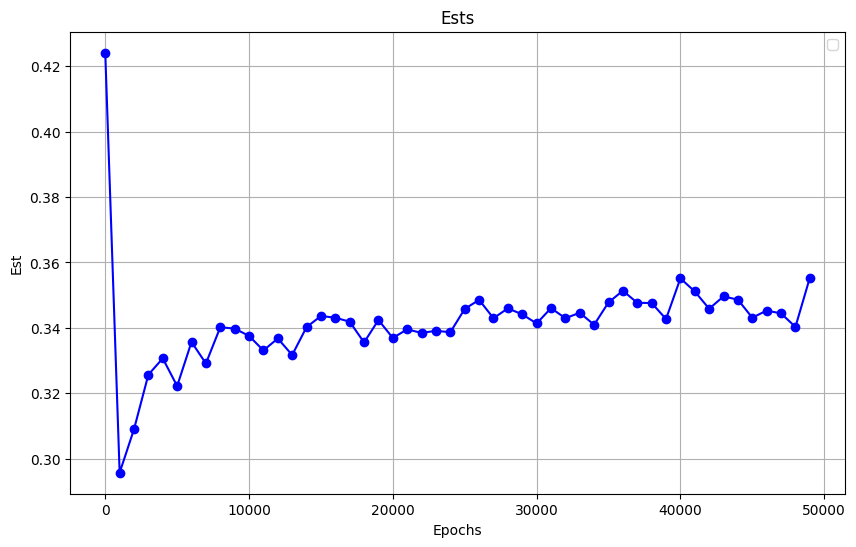

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


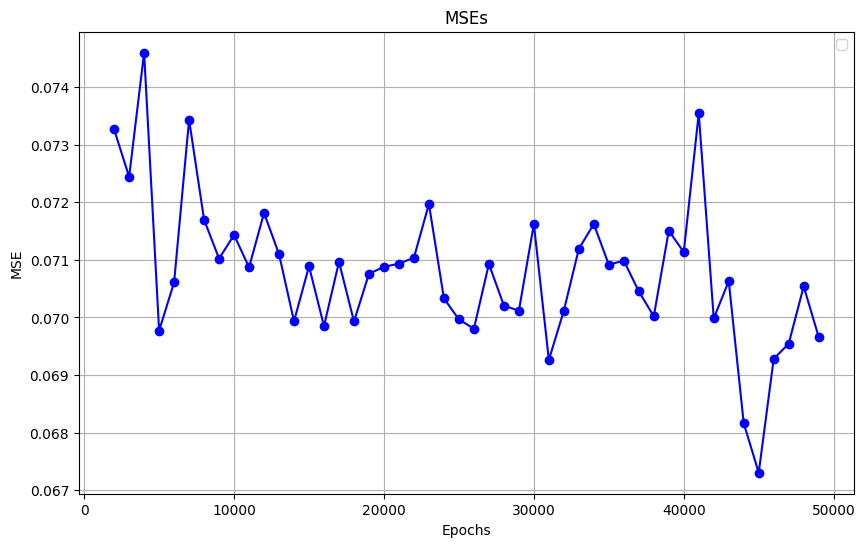

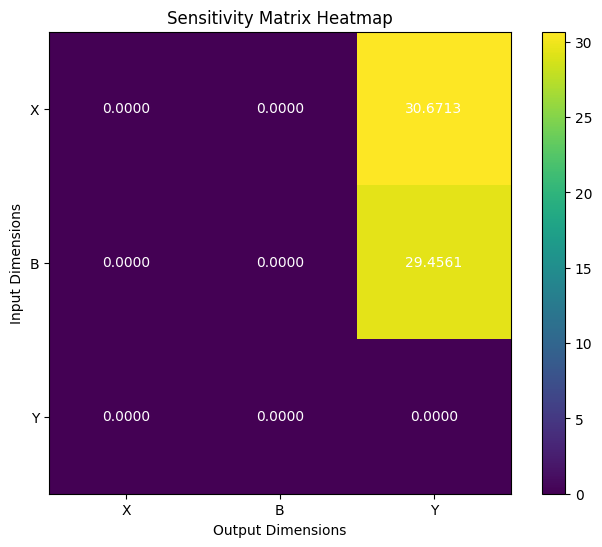

ATE: [0.3] est ATE: 0.34835662363737824
1.7999999999999998
step 0 of 50000: train_loss 0.4526, val loss 0.4559
step 1000 of 50000: train_loss 0.0789, val loss 0.0775
step 2000 of 50000: train_loss 0.0620, val loss 0.0605
step 3000 of 50000: train_loss 0.0616, val loss 0.0597
step 4000 of 50000: train_loss 0.0623, val loss 0.0601
step 5000 of 50000: train_loss 0.0596, val loss 0.0571
step 6000 of 50000: train_loss 0.0598, val loss 0.0587
step 7000 of 50000: train_loss 0.0614, val loss 0.0583
step 8000 of 50000: train_loss 0.0612, val loss 0.0584
step 9000 of 50000: train_loss 0.0620, val loss 0.0590
step 10000 of 50000: train_loss 0.0626, val loss 0.0564
step 11000 of 50000: train_loss 0.0621, val loss 0.0577
step 12000 of 50000: train_loss 0.0608, val loss 0.0571
step 13000 of 50000: train_loss 0.0625, val loss 0.0581
step 14000 of 50000: train_loss 0.0599, val loss 0.0586
step 15000 of 50000: train_loss 0.0611, val loss 0.0563
step 16000 of 50000: train_loss 0.0625, val loss 0.0570
st

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


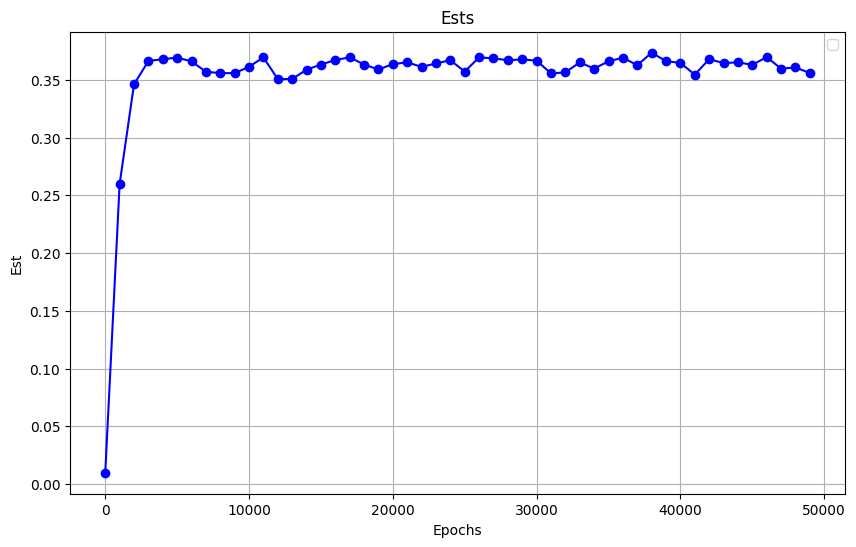

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


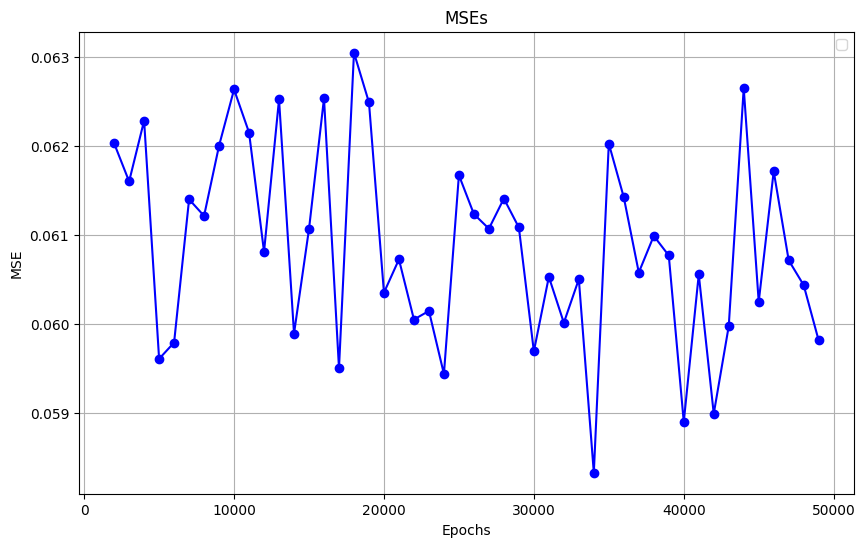

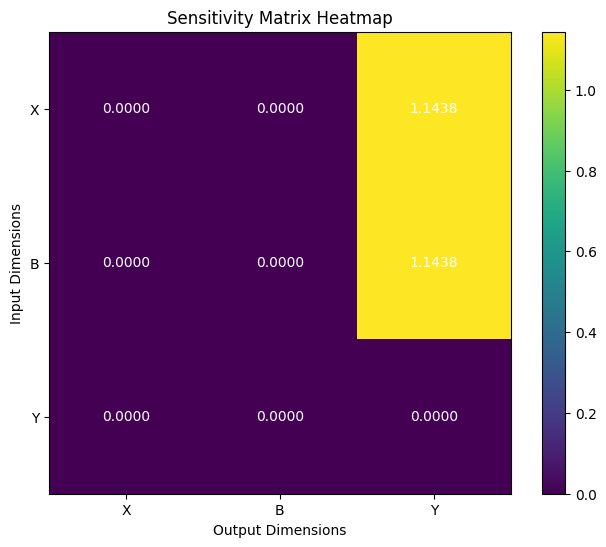

ATE: [0.3] est ATE: 0.3716143916773796
1.9999999999999998
step 0 of 50000: train_loss 0.5643, val loss 0.5664
step 1000 of 50000: train_loss 0.1255, val loss 0.1276
step 2000 of 50000: train_loss 0.0496, val loss 0.0443
step 3000 of 50000: train_loss 0.0474, val loss 0.0462
step 4000 of 50000: train_loss 0.0470, val loss 0.0460
step 5000 of 50000: train_loss 0.0475, val loss 0.0451
step 6000 of 50000: train_loss 0.0482, val loss 0.0444
step 7000 of 50000: train_loss 0.0494, val loss 0.0454
step 8000 of 50000: train_loss 0.0469, val loss 0.0461
step 9000 of 50000: train_loss 0.0483, val loss 0.0454
step 10000 of 50000: train_loss 0.0481, val loss 0.0460
step 11000 of 50000: train_loss 0.0476, val loss 0.0449
step 12000 of 50000: train_loss 0.0482, val loss 0.0453
step 13000 of 50000: train_loss 0.0486, val loss 0.0457
step 14000 of 50000: train_loss 0.0477, val loss 0.0475
step 15000 of 50000: train_loss 0.0488, val loss 0.0471
step 16000 of 50000: train_loss 0.0475, val loss 0.0450
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


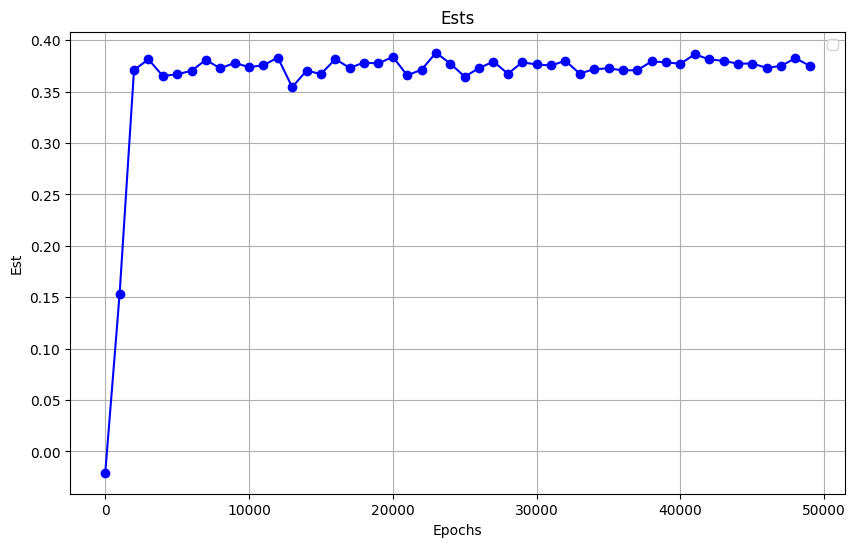

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


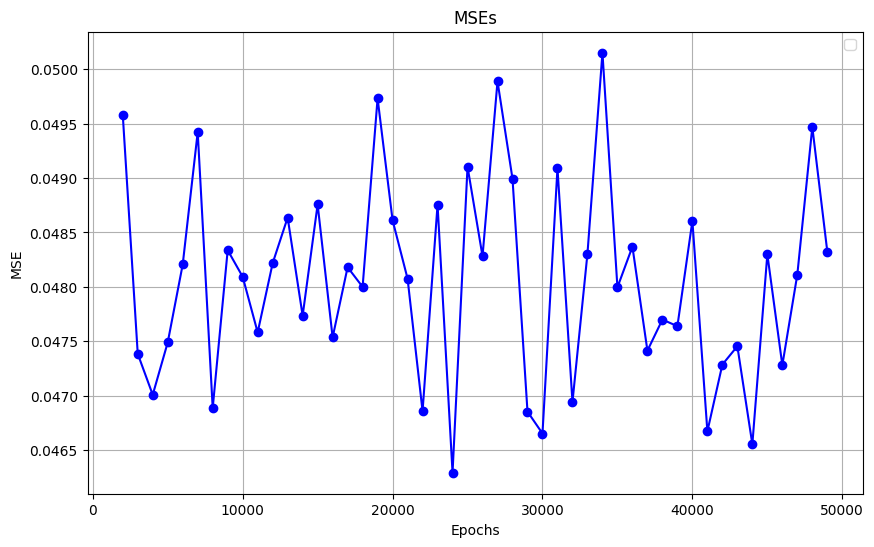

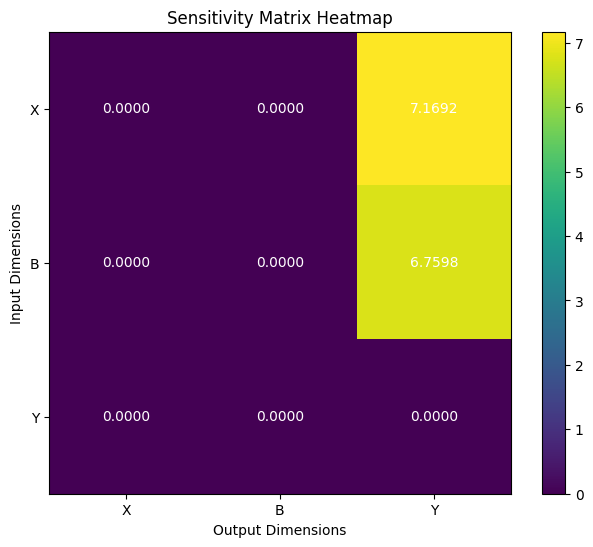

ATE: [0.3] est ATE: 0.3736764186003804
2.1999999999999997
step 0 of 50000: train_loss 0.5808, val loss 0.5904
step 1000 of 50000: train_loss 0.0553, val loss 0.0544
step 2000 of 50000: train_loss 0.0494, val loss 0.0479
step 3000 of 50000: train_loss 0.0436, val loss 0.0442
step 4000 of 50000: train_loss 0.0442, val loss 0.0419
step 5000 of 50000: train_loss 0.0427, val loss 0.0404
step 6000 of 50000: train_loss 0.0424, val loss 0.0415
step 7000 of 50000: train_loss 0.0405, val loss 0.0413
step 8000 of 50000: train_loss 0.0408, val loss 0.0416
step 9000 of 50000: train_loss 0.0411, val loss 0.0420
step 10000 of 50000: train_loss 0.0419, val loss 0.0394
step 11000 of 50000: train_loss 0.0405, val loss 0.0405
step 12000 of 50000: train_loss 0.0406, val loss 0.0387
step 13000 of 50000: train_loss 0.0401, val loss 0.0399
step 14000 of 50000: train_loss 0.0419, val loss 0.0400
step 15000 of 50000: train_loss 0.0418, val loss 0.0387
step 16000 of 50000: train_loss 0.0412, val loss 0.0388
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


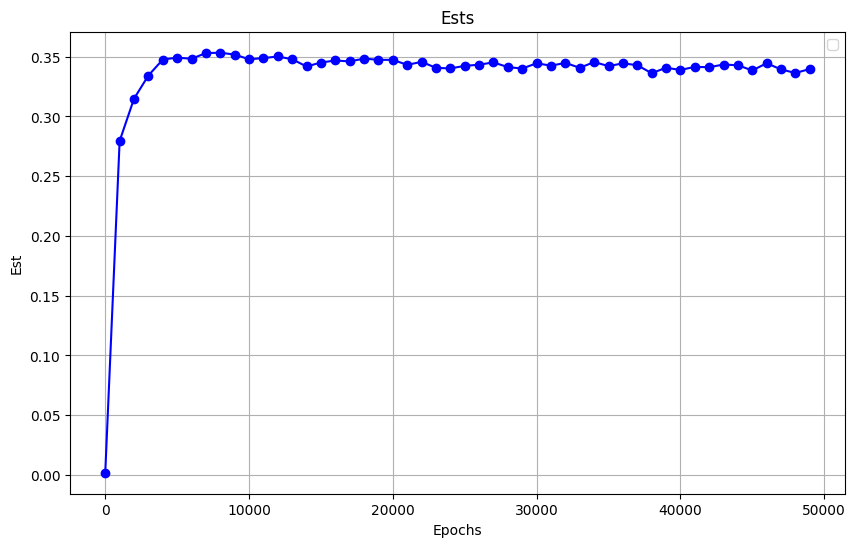

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


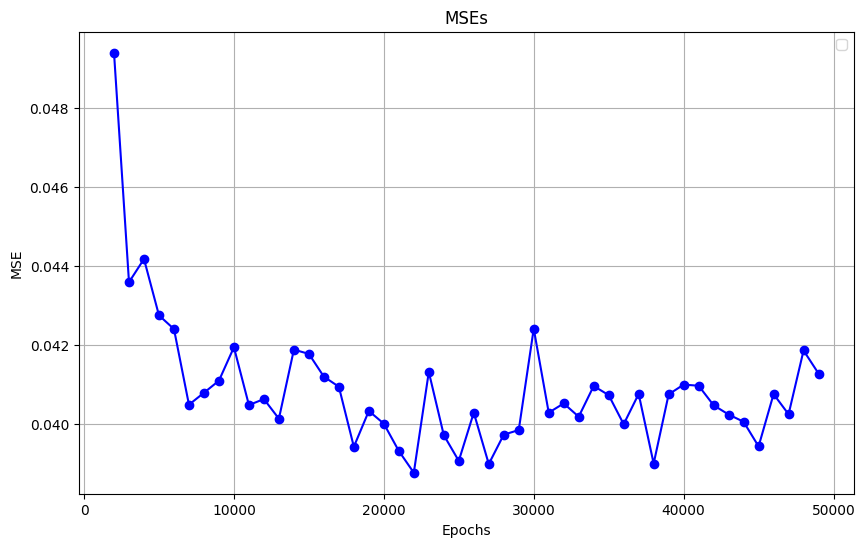

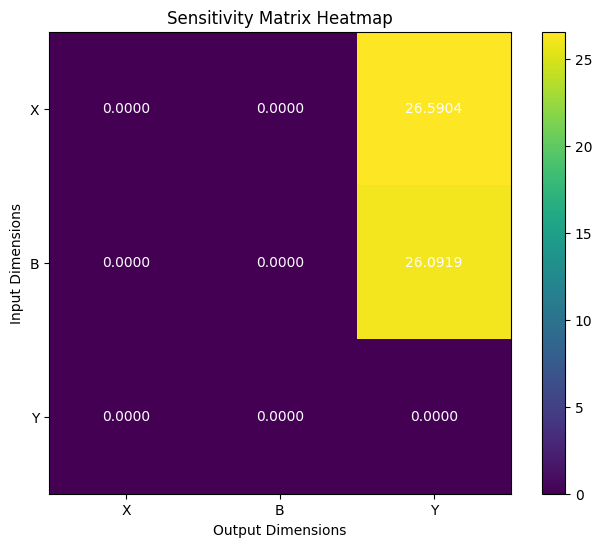

ATE: [0.3] est ATE: 0.3466193006595969
2.4
step 0 of 50000: train_loss 0.6599, val loss 0.6594
step 1000 of 50000: train_loss 0.0785, val loss 0.0769
step 2000 of 50000: train_loss 0.0363, val loss 0.0365
step 3000 of 50000: train_loss 0.0333, val loss 0.0330
step 4000 of 50000: train_loss 0.0324, val loss 0.0329
step 5000 of 50000: train_loss 0.0343, val loss 0.0338
step 6000 of 50000: train_loss 0.0328, val loss 0.0343
step 7000 of 50000: train_loss 0.0342, val loss 0.0316
step 8000 of 50000: train_loss 0.0327, val loss 0.0332
step 9000 of 50000: train_loss 0.0331, val loss 0.0326
step 10000 of 50000: train_loss 0.0324, val loss 0.0325
step 11000 of 50000: train_loss 0.0320, val loss 0.0328
step 12000 of 50000: train_loss 0.0328, val loss 0.0315
step 13000 of 50000: train_loss 0.0335, val loss 0.0323
step 14000 of 50000: train_loss 0.0320, val loss 0.0318
step 15000 of 50000: train_loss 0.0324, val loss 0.0328
step 16000 of 50000: train_loss 0.0330, val loss 0.0332
step 17000 of 5000

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


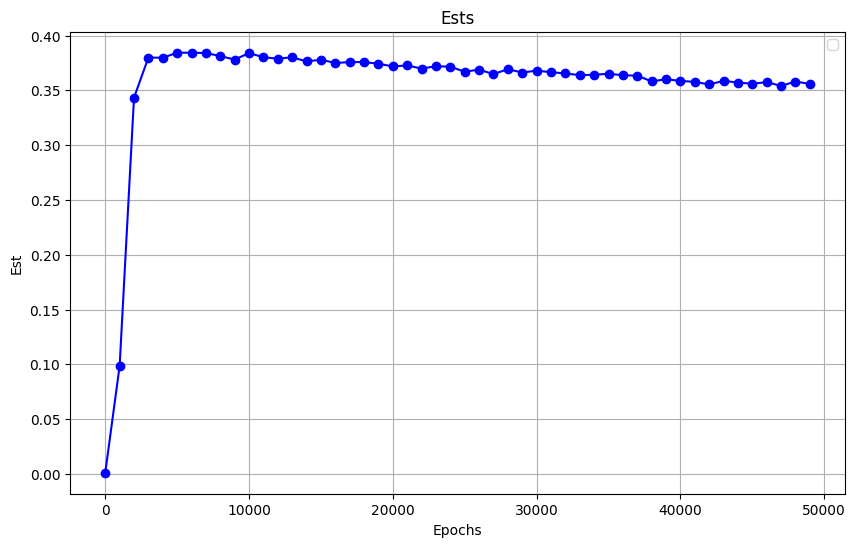

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


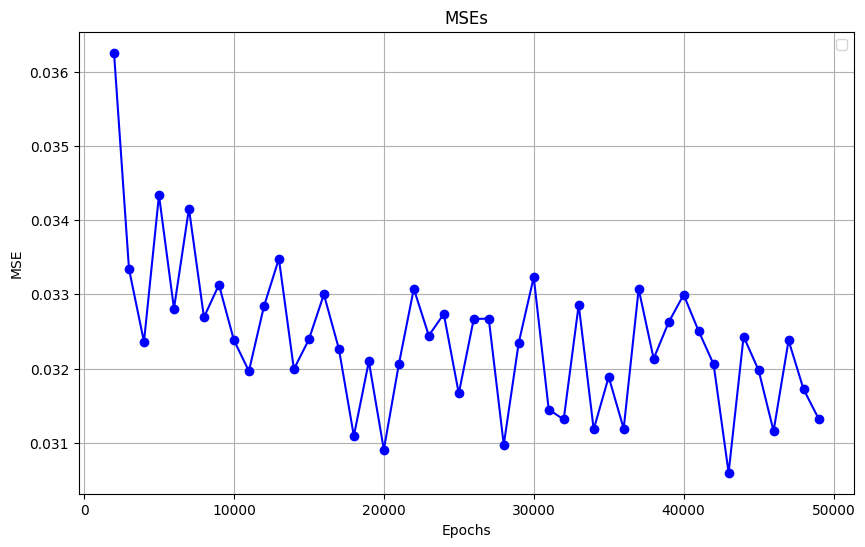

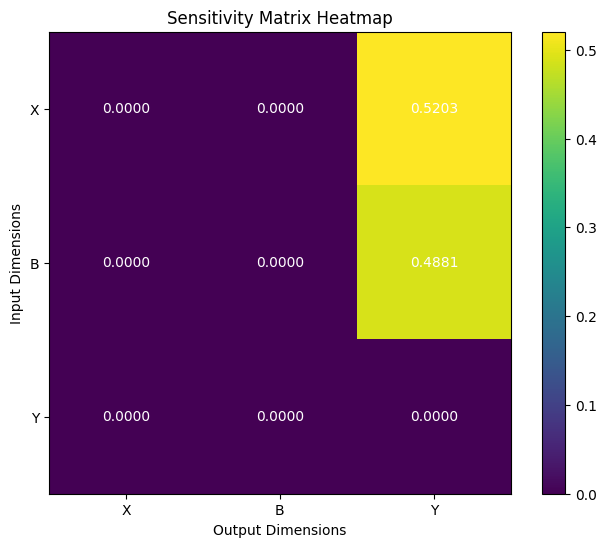

ATE: [0.3] est ATE: 0.35557446001678705
2.6
step 0 of 50000: train_loss 0.7576, val loss 0.7584
step 1000 of 50000: train_loss 0.1045, val loss 0.1062
step 2000 of 50000: train_loss 0.1030, val loss 0.1031
step 3000 of 50000: train_loss 0.0995, val loss 0.1007
step 4000 of 50000: train_loss 0.0984, val loss 0.0983
step 5000 of 50000: train_loss 0.0954, val loss 0.0964
step 6000 of 50000: train_loss 0.0832, val loss 0.0870
step 7000 of 50000: train_loss 0.0541, val loss 0.0537
step 8000 of 50000: train_loss 0.0324, val loss 0.0349
step 9000 of 50000: train_loss 0.0272, val loss 0.0302
step 10000 of 50000: train_loss 0.0265, val loss 0.0274
step 11000 of 50000: train_loss 0.0253, val loss 0.0274
step 12000 of 50000: train_loss 0.0251, val loss 0.0273
step 13000 of 50000: train_loss 0.0276, val loss 0.0276
step 14000 of 50000: train_loss 0.0255, val loss 0.0276
step 15000 of 50000: train_loss 0.0273, val loss 0.0273
step 16000 of 50000: train_loss 0.0266, val loss 0.0283
step 17000 of 500

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


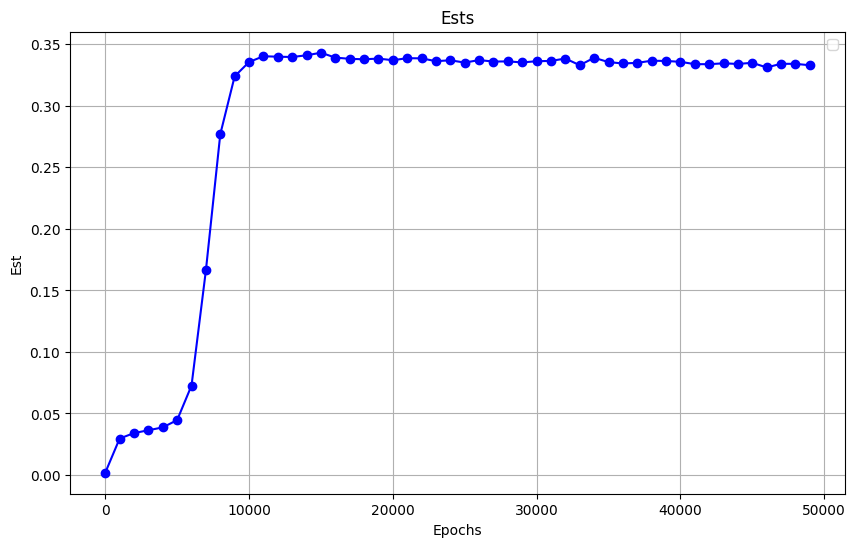

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


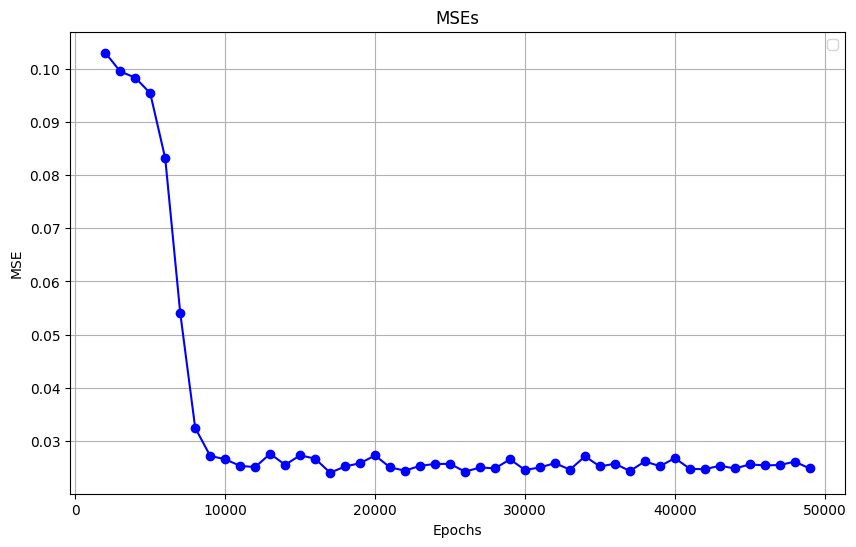

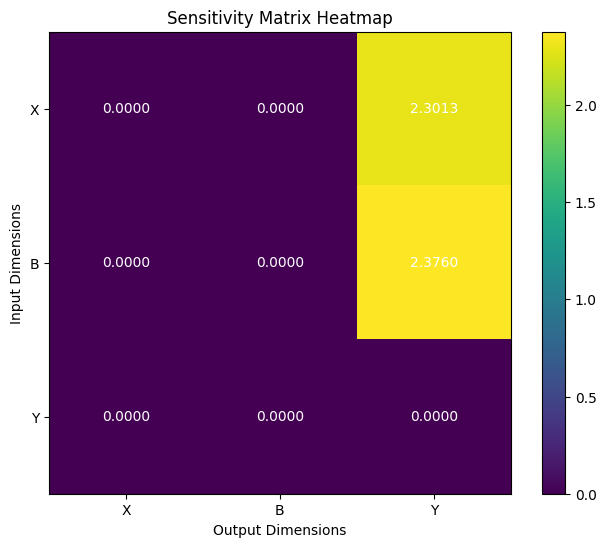

ATE: [0.3] est ATE: 0.33474787387251853
2.8000000000000003
step 0 of 50000: train_loss 0.9101, val loss 0.9034
step 1000 of 50000: train_loss 0.0708, val loss 0.0725
step 2000 of 50000: train_loss 0.0523, val loss 0.0532
step 3000 of 50000: train_loss 0.0431, val loss 0.0439
step 4000 of 50000: train_loss 0.0396, val loss 0.0399
step 5000 of 50000: train_loss 0.0387, val loss 0.0381
step 6000 of 50000: train_loss 0.0382, val loss 0.0380
step 7000 of 50000: train_loss 0.0374, val loss 0.0366
step 8000 of 50000: train_loss 0.0358, val loss 0.0372
step 9000 of 50000: train_loss 0.0370, val loss 0.0367
step 10000 of 50000: train_loss 0.0348, val loss 0.0361
step 11000 of 50000: train_loss 0.0359, val loss 0.0363
step 12000 of 50000: train_loss 0.0353, val loss 0.0364
step 13000 of 50000: train_loss 0.0342, val loss 0.0347
step 14000 of 50000: train_loss 0.0353, val loss 0.0355
step 15000 of 50000: train_loss 0.0343, val loss 0.0343
step 16000 of 50000: train_loss 0.0341, val loss 0.0340
st

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


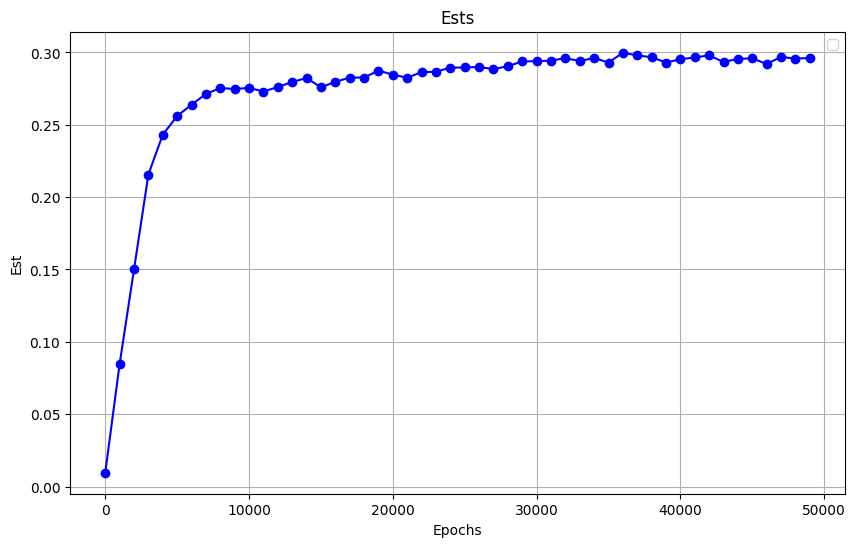

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


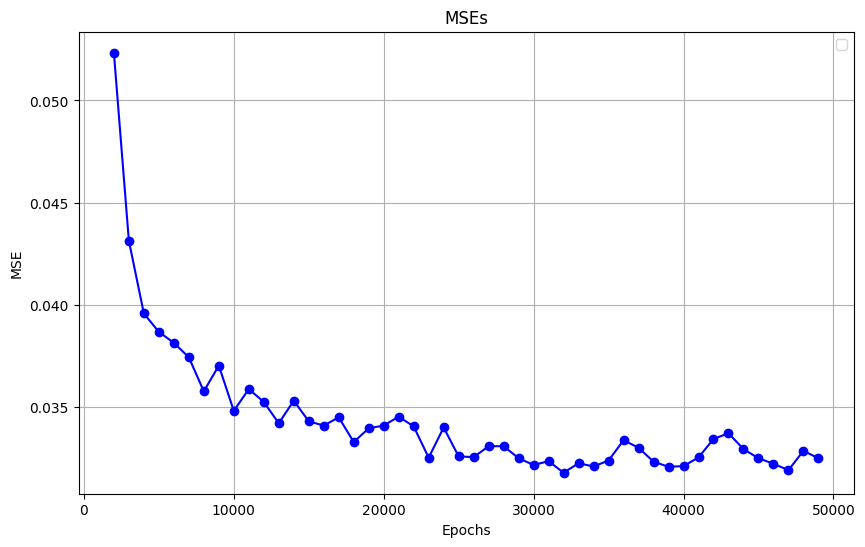

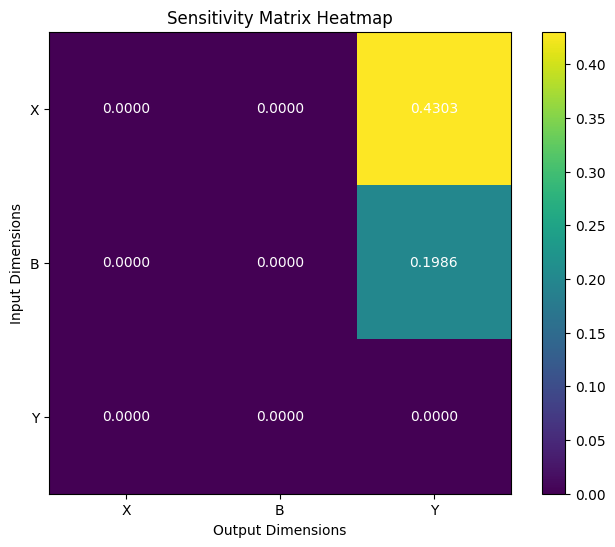

ATE: [0.3] est ATE: 0.2932986759328842
3.0000000000000004
step 0 of 50000: train_loss 0.9713, val loss 0.9511
step 1000 of 50000: train_loss 0.0548, val loss 0.0526
step 2000 of 50000: train_loss 0.0317, val loss 0.0298
step 3000 of 50000: train_loss 0.0253, val loss 0.0244
step 4000 of 50000: train_loss 0.0230, val loss 0.0227
step 5000 of 50000: train_loss 0.0213, val loss 0.0203
step 6000 of 50000: train_loss 0.0207, val loss 0.0203
step 7000 of 50000: train_loss 0.0198, val loss 0.0198
step 8000 of 50000: train_loss 0.0208, val loss 0.0189
step 9000 of 50000: train_loss 0.0187, val loss 0.0186
step 10000 of 50000: train_loss 0.0199, val loss 0.0187
step 11000 of 50000: train_loss 0.0187, val loss 0.0177
step 12000 of 50000: train_loss 0.0171, val loss 0.0178
step 13000 of 50000: train_loss 0.0180, val loss 0.0179
step 14000 of 50000: train_loss 0.0190, val loss 0.0170
step 15000 of 50000: train_loss 0.0179, val loss 0.0187
step 16000 of 50000: train_loss 0.0176, val loss 0.0176
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


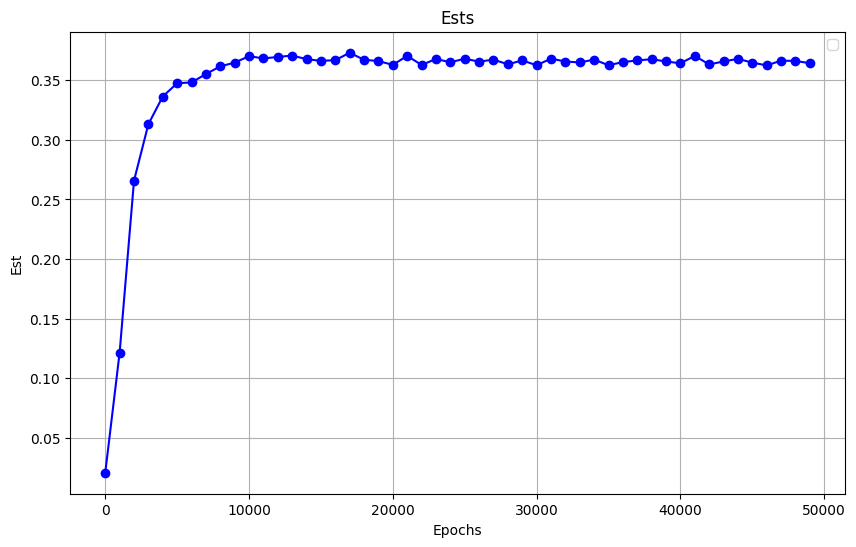

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


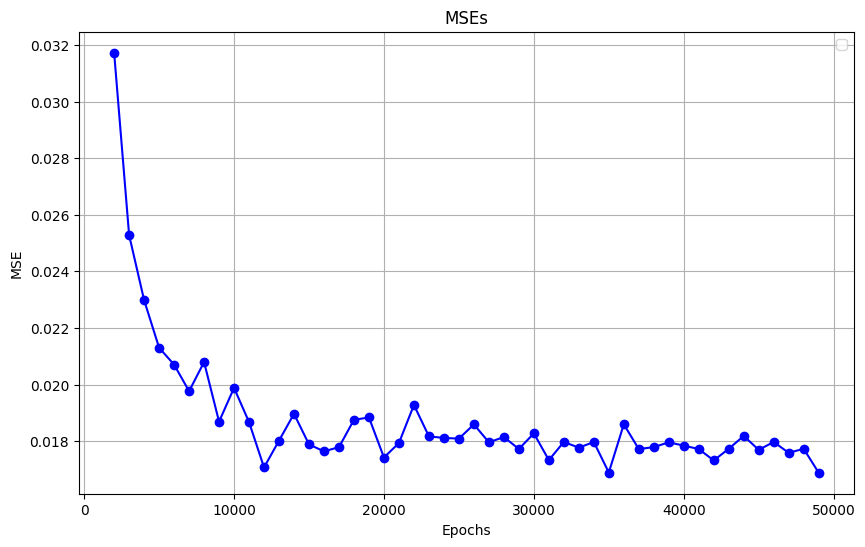

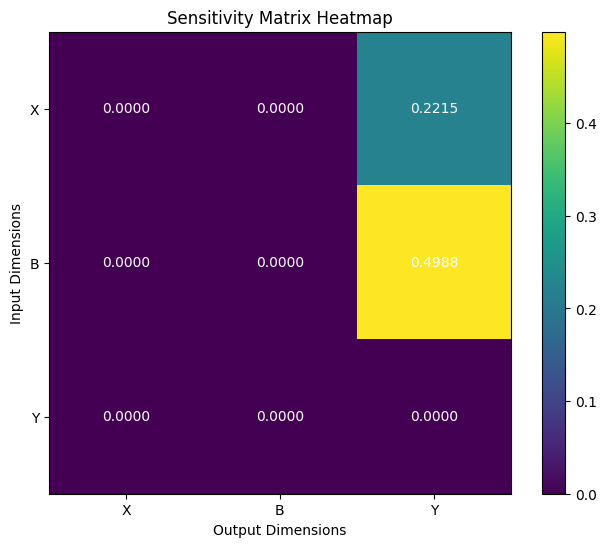

ATE: [0.3] est ATE: 0.3639128299966454
3.2000000000000006
step 0 of 50000: train_loss 1.1221, val loss 1.1305
step 1000 of 50000: train_loss 0.1531, val loss 0.1517
step 2000 of 50000: train_loss 0.0225, val loss 0.0227
step 3000 of 50000: train_loss 0.0184, val loss 0.0181
step 4000 of 50000: train_loss 0.0188, val loss 0.0175
step 5000 of 50000: train_loss 0.0176, val loss 0.0155
step 6000 of 50000: train_loss 0.0170, val loss 0.0165
step 7000 of 50000: train_loss 0.0167, val loss 0.0150
step 8000 of 50000: train_loss 0.0155, val loss 0.0156
step 9000 of 50000: train_loss 0.0150, val loss 0.0142
step 10000 of 50000: train_loss 0.0150, val loss 0.0138
step 11000 of 50000: train_loss 0.0153, val loss 0.0144
step 12000 of 50000: train_loss 0.0141, val loss 0.0135
step 13000 of 50000: train_loss 0.0140, val loss 0.0135
step 14000 of 50000: train_loss 0.0143, val loss 0.0135
step 15000 of 50000: train_loss 0.0131, val loss 0.0128
step 16000 of 50000: train_loss 0.0136, val loss 0.0128
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


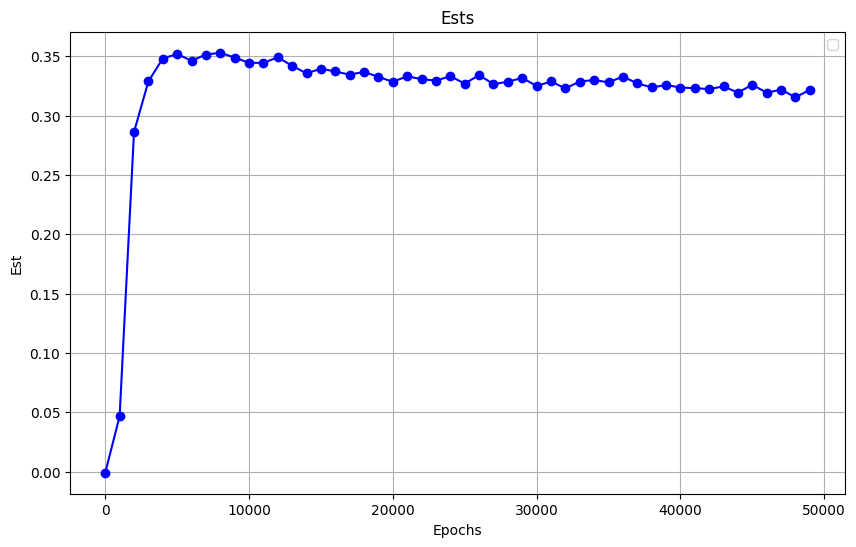

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


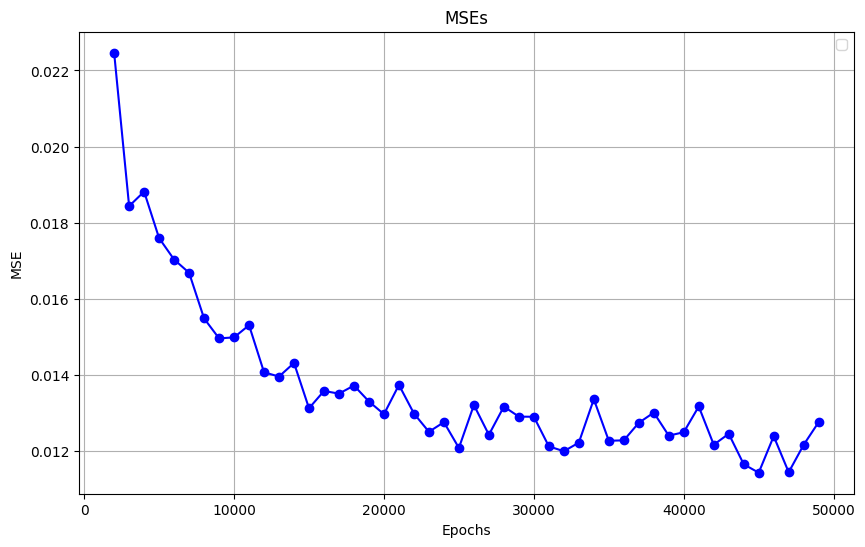

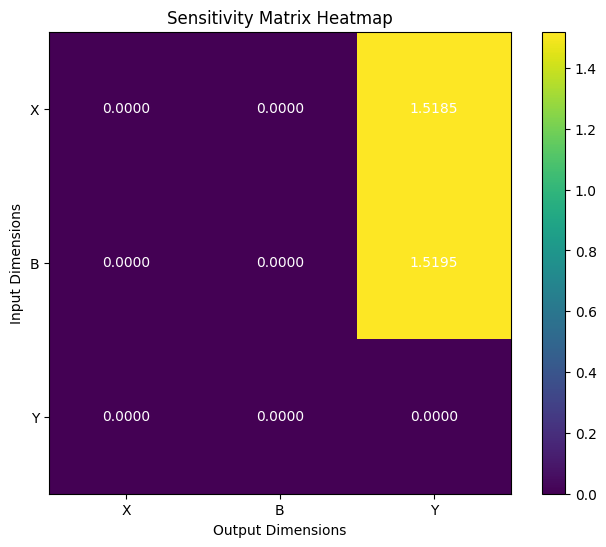

ATE: [0.3] est ATE: 0.32253952850878237
3.400000000000001
step 0 of 50000: train_loss 8.4406, val loss 8.4265
step 1000 of 50000: train_loss 0.1961, val loss 0.1958
step 2000 of 50000: train_loss 0.1892, val loss 0.1869
step 3000 of 50000: train_loss 0.1842, val loss 0.1830
step 4000 of 50000: train_loss 0.1801, val loss 0.1810
step 5000 of 50000: train_loss 0.1825, val loss 0.1809
step 6000 of 50000: train_loss 0.1787, val loss 0.1796
step 7000 of 50000: train_loss 0.1769, val loss 0.1784
step 8000 of 50000: train_loss 0.1788, val loss 0.1772
step 9000 of 50000: train_loss 0.1803, val loss 0.1789
step 10000 of 50000: train_loss 0.1072, val loss 0.1096
step 11000 of 50000: train_loss 0.0132, val loss 0.0121
step 12000 of 50000: train_loss 0.0130, val loss 0.0128
step 13000 of 50000: train_loss 0.0125, val loss 0.0117
step 14000 of 50000: train_loss 0.0128, val loss 0.0114
step 15000 of 50000: train_loss 0.0124, val loss 0.0127
step 16000 of 50000: train_loss 0.0129, val loss 0.0126
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


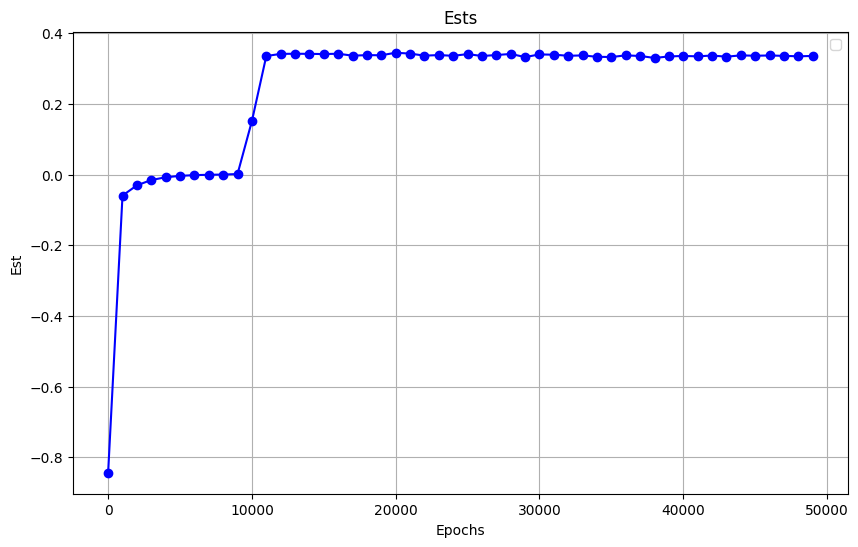

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


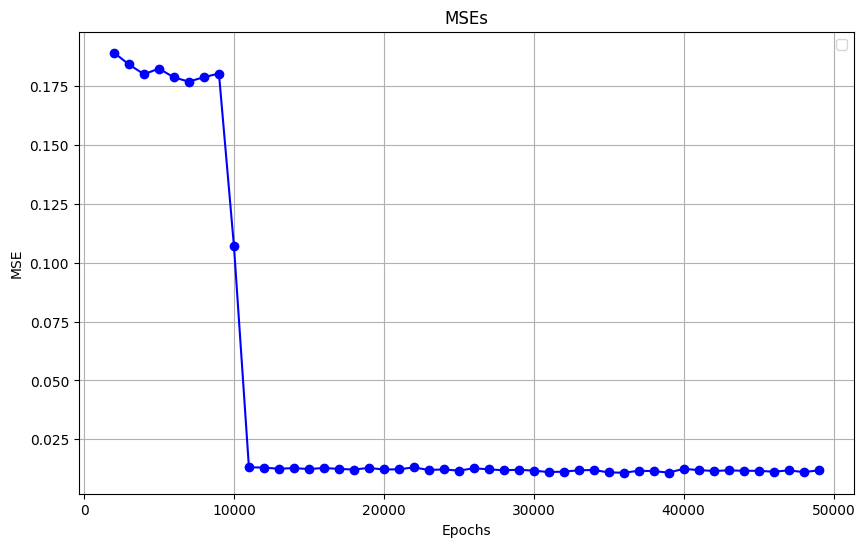

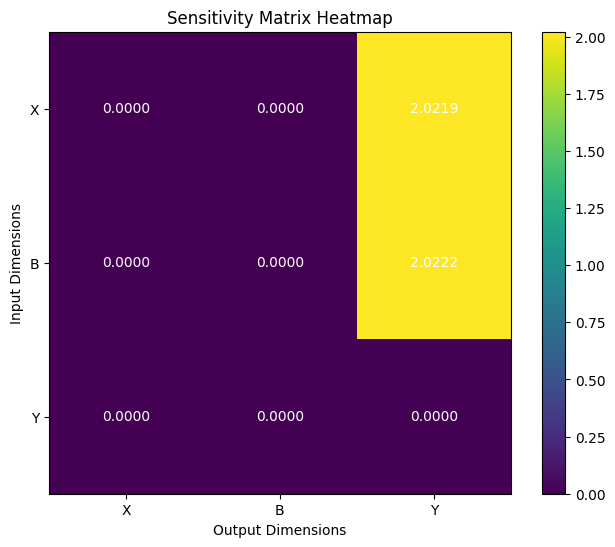

ATE: [0.3] est ATE: 0.3344797118371725
3.600000000000001
step 0 of 50000: train_loss 1.4664, val loss 1.4839
step 1000 of 50000: train_loss 0.1647, val loss 0.1677
step 2000 of 50000: train_loss 0.0748, val loss 0.0759
step 3000 of 50000: train_loss 0.0270, val loss 0.0284
step 4000 of 50000: train_loss 0.0166, val loss 0.0173
step 5000 of 50000: train_loss 0.0153, val loss 0.0164
step 6000 of 50000: train_loss 0.0147, val loss 0.0157
step 7000 of 50000: train_loss 0.0140, val loss 0.0151
step 8000 of 50000: train_loss 0.0140, val loss 0.0154
step 9000 of 50000: train_loss 0.0130, val loss 0.0150
step 10000 of 50000: train_loss 0.0128, val loss 0.0144
step 11000 of 50000: train_loss 0.0129, val loss 0.0138
step 12000 of 50000: train_loss 0.0119, val loss 0.0129
step 13000 of 50000: train_loss 0.0121, val loss 0.0136
step 14000 of 50000: train_loss 0.0115, val loss 0.0120
step 15000 of 50000: train_loss 0.0117, val loss 0.0132
step 16000 of 50000: train_loss 0.0108, val loss 0.0116
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


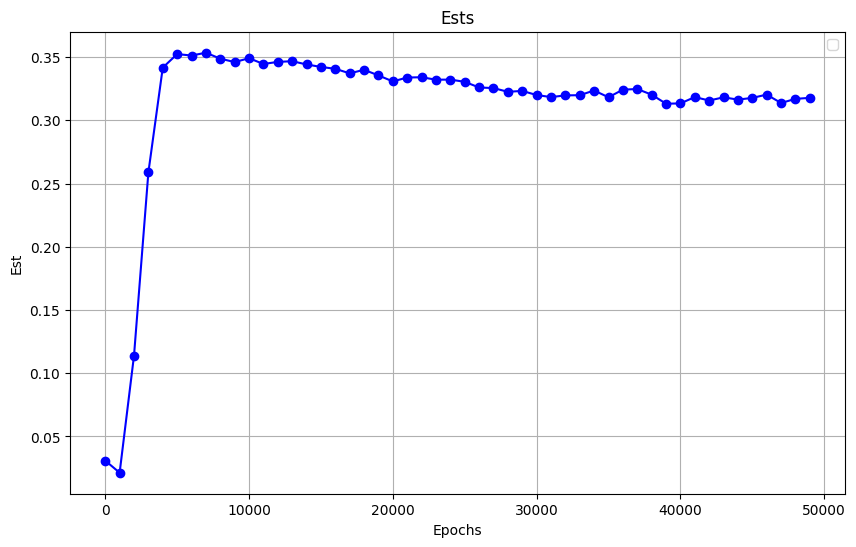

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


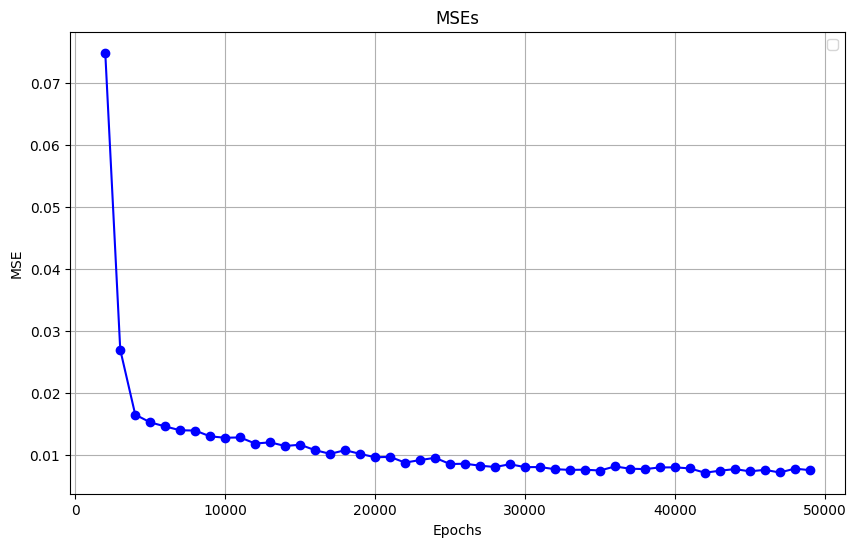

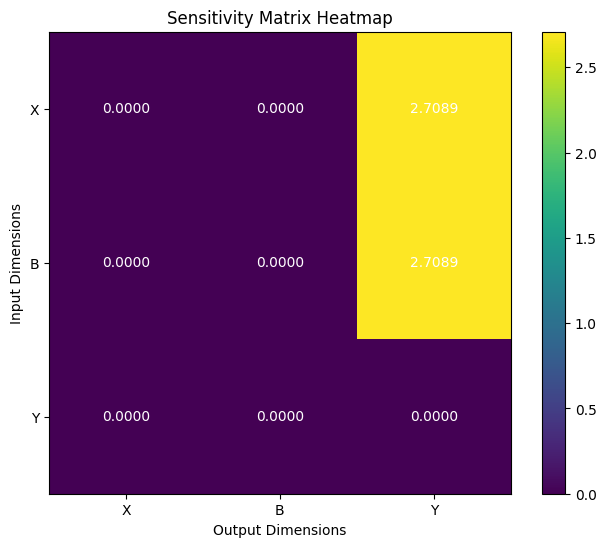

ATE: [0.3] est ATE: 0.3168758616936207
3.800000000000001
step 0 of 50000: train_loss 3.0151, val loss 3.0332
step 1000 of 50000: train_loss 0.1669, val loss 0.1638
step 2000 of 50000: train_loss 0.1614, val loss 0.1578
step 3000 of 50000: train_loss 0.0934, val loss 0.0924
step 4000 of 50000: train_loss 0.0178, val loss 0.0159
step 5000 of 50000: train_loss 0.0150, val loss 0.0140
step 6000 of 50000: train_loss 0.0147, val loss 0.0137
step 7000 of 50000: train_loss 0.0135, val loss 0.0125
step 8000 of 50000: train_loss 0.0142, val loss 0.0131
step 9000 of 50000: train_loss 0.0137, val loss 0.0129
step 10000 of 50000: train_loss 0.0136, val loss 0.0127
step 11000 of 50000: train_loss 0.0137, val loss 0.0127
step 12000 of 50000: train_loss 0.0129, val loss 0.0126
step 13000 of 50000: train_loss 0.0132, val loss 0.0129
step 14000 of 50000: train_loss 0.0128, val loss 0.0123
step 15000 of 50000: train_loss 0.0129, val loss 0.0121
step 16000 of 50000: train_loss 0.0127, val loss 0.0115
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


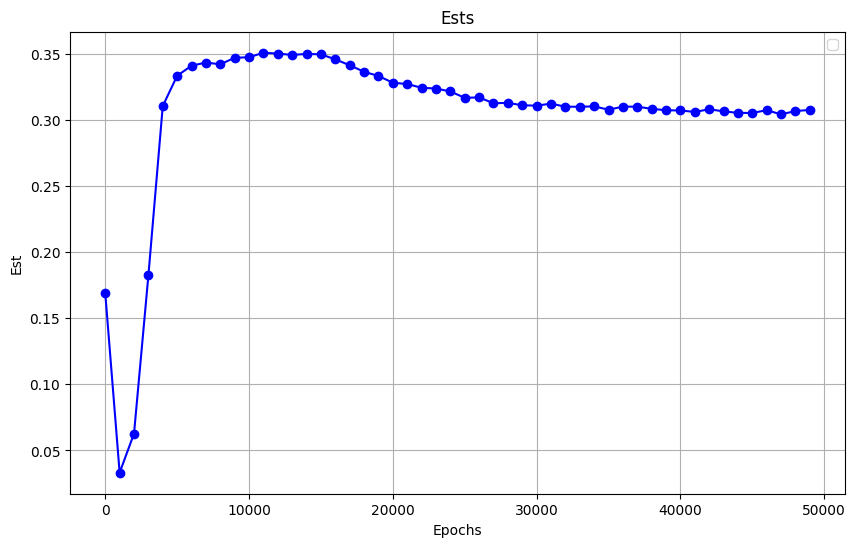

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


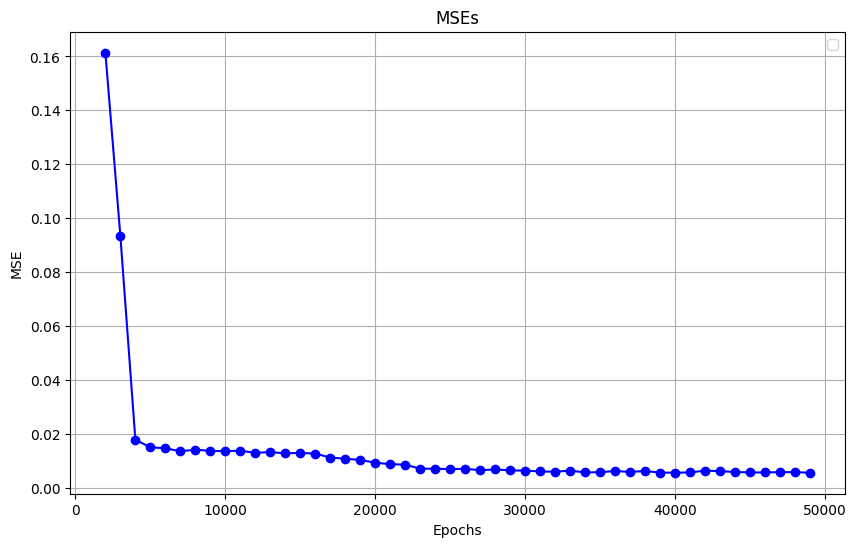

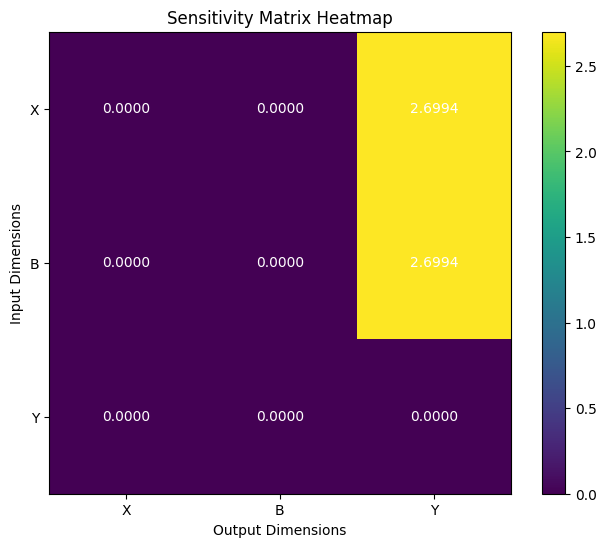

ATE: [0.3] est ATE: 0.3045302308881283
4.000000000000001
step 0 of 50000: train_loss 1.6542, val loss 1.6330
step 1000 of 50000: train_loss 0.0857, val loss 0.0889
step 2000 of 50000: train_loss 0.0860, val loss 0.0885
step 3000 of 50000: train_loss 0.0853, val loss 0.0893
step 4000 of 50000: train_loss 0.0854, val loss 0.0865
step 5000 of 50000: train_loss 0.0836, val loss 0.0874
step 6000 of 50000: train_loss 0.0815, val loss 0.0840
step 7000 of 50000: train_loss 0.0742, val loss 0.0771
step 8000 of 50000: train_loss 0.0529, val loss 0.0543
step 9000 of 50000: train_loss 0.0235, val loss 0.0252
step 10000 of 50000: train_loss 0.0115, val loss 0.0131
step 11000 of 50000: train_loss 0.0086, val loss 0.0096
step 12000 of 50000: train_loss 0.0066, val loss 0.0078
step 13000 of 50000: train_loss 0.0066, val loss 0.0074
step 14000 of 50000: train_loss 0.0062, val loss 0.0065
step 15000 of 50000: train_loss 0.0057, val loss 0.0064
step 16000 of 50000: train_loss 0.0054, val loss 0.0059
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


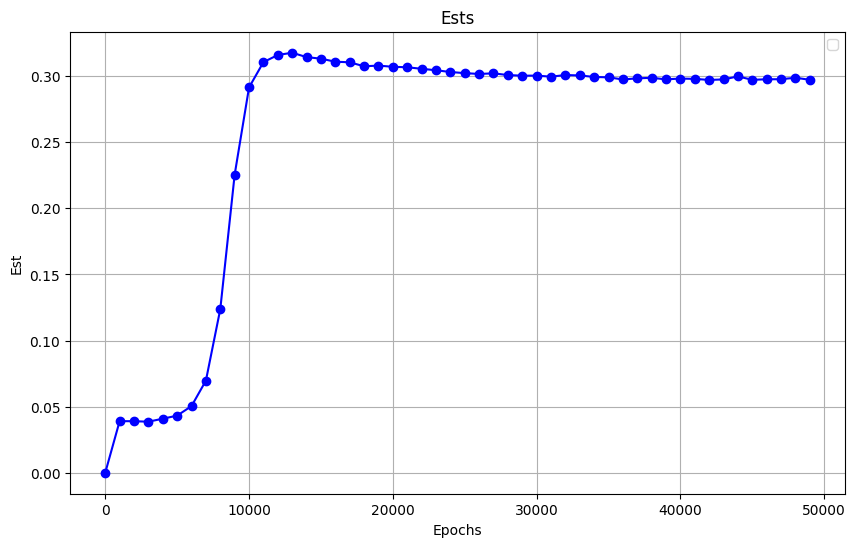

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


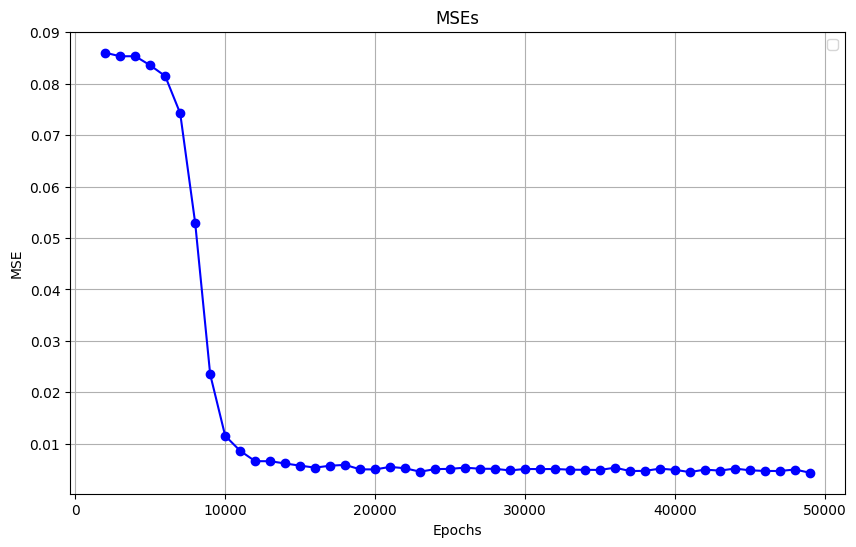

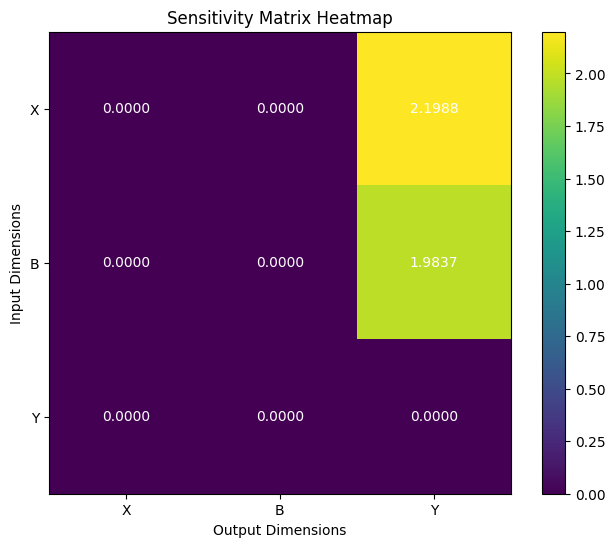

ATE: [0.3] est ATE: 0.2977015878653526
4.200000000000001
step 0 of 50000: train_loss 1.5833, val loss 1.5893
step 1000 of 50000: train_loss 0.0279, val loss 0.0283
step 2000 of 50000: train_loss 0.0069, val loss 0.0073
step 3000 of 50000: train_loss 0.0065, val loss 0.0062
step 4000 of 50000: train_loss 0.0059, val loss 0.0062
step 5000 of 50000: train_loss 0.0060, val loss 0.0061
step 6000 of 50000: train_loss 0.0057, val loss 0.0062
step 7000 of 50000: train_loss 0.0061, val loss 0.0058
step 8000 of 50000: train_loss 0.0059, val loss 0.0060
step 9000 of 50000: train_loss 0.0059, val loss 0.0058
step 10000 of 50000: train_loss 0.0061, val loss 0.0058
step 11000 of 50000: train_loss 0.0059, val loss 0.0056
step 12000 of 50000: train_loss 0.0056, val loss 0.0056
step 13000 of 50000: train_loss 0.0053, val loss 0.0054
step 14000 of 50000: train_loss 0.0055, val loss 0.0054
step 15000 of 50000: train_loss 0.0054, val loss 0.0053
step 16000 of 50000: train_loss 0.0052, val loss 0.0058
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


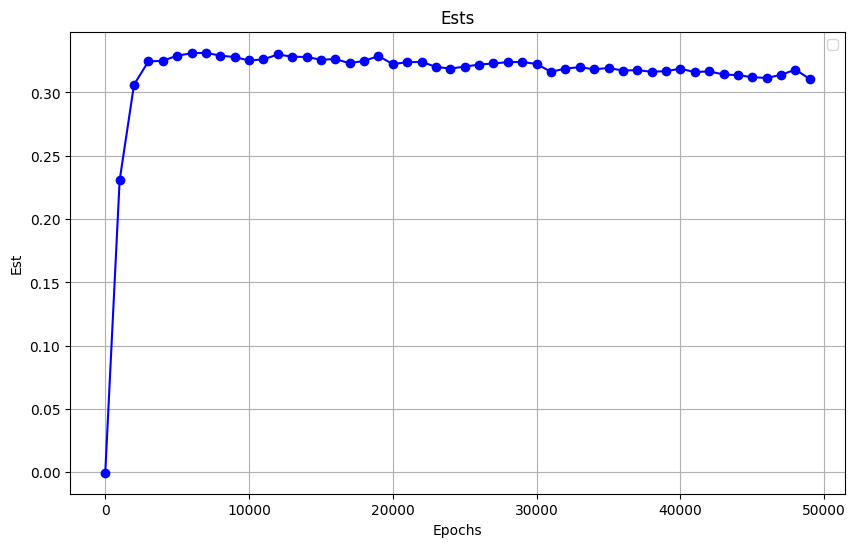

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


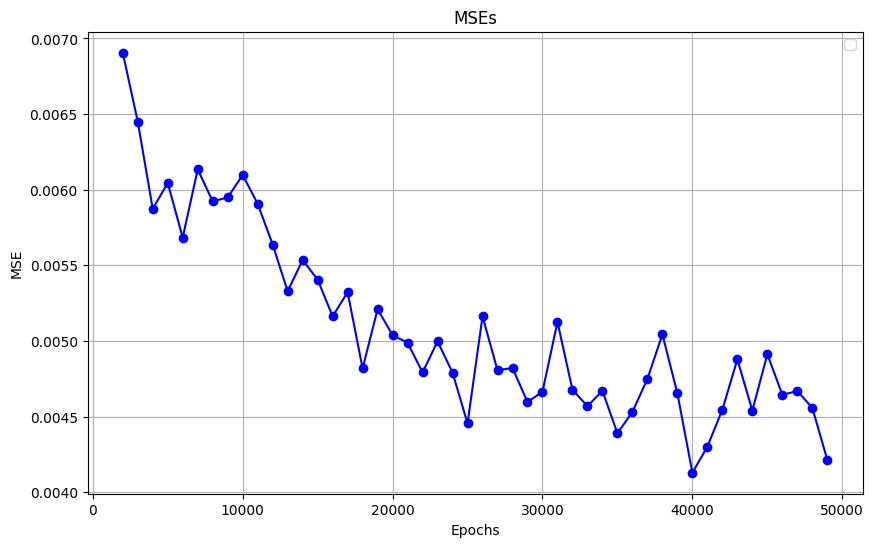

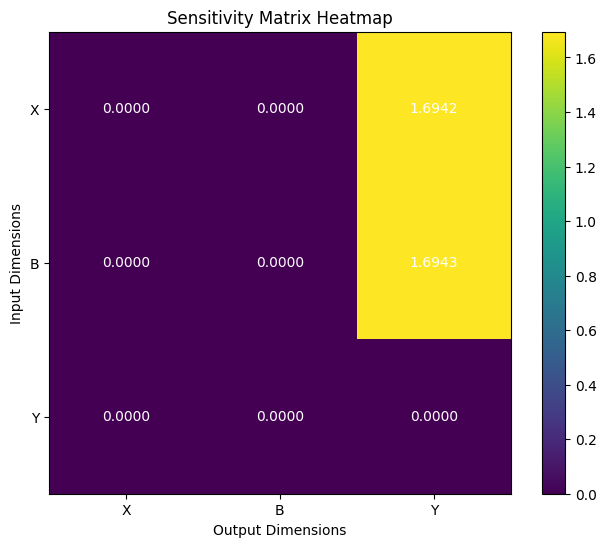

ATE: [0.3] est ATE: 0.31489393789768216
4.400000000000001
step 0 of 50000: train_loss 1.6617, val loss 1.6758
step 1000 of 50000: train_loss 0.0846, val loss 0.0852
step 2000 of 50000: train_loss 0.0591, val loss 0.0596
step 3000 of 50000: train_loss 0.0317, val loss 0.0315
step 4000 of 50000: train_loss 0.0208, val loss 0.0199
step 5000 of 50000: train_loss 0.0129, val loss 0.0124
step 6000 of 50000: train_loss 0.0086, val loss 0.0080
step 7000 of 50000: train_loss 0.0059, val loss 0.0057
step 8000 of 50000: train_loss 0.0052, val loss 0.0049
step 9000 of 50000: train_loss 0.0048, val loss 0.0045
step 10000 of 50000: train_loss 0.0050, val loss 0.0043
step 11000 of 50000: train_loss 0.0043, val loss 0.0046
step 12000 of 50000: train_loss 0.0046, val loss 0.0042
step 13000 of 50000: train_loss 0.0047, val loss 0.0044
step 14000 of 50000: train_loss 0.0047, val loss 0.0044
step 15000 of 50000: train_loss 0.0047, val loss 0.0045
step 16000 of 50000: train_loss 0.0047, val loss 0.0043
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


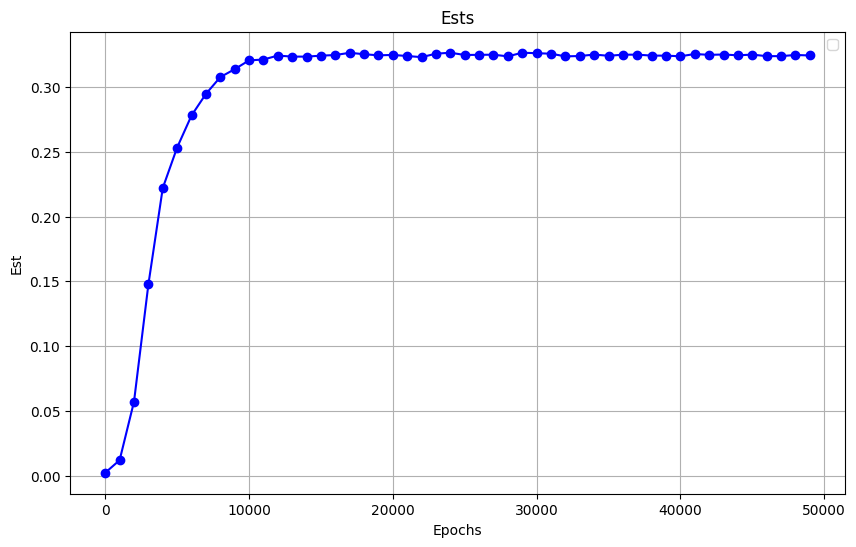

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


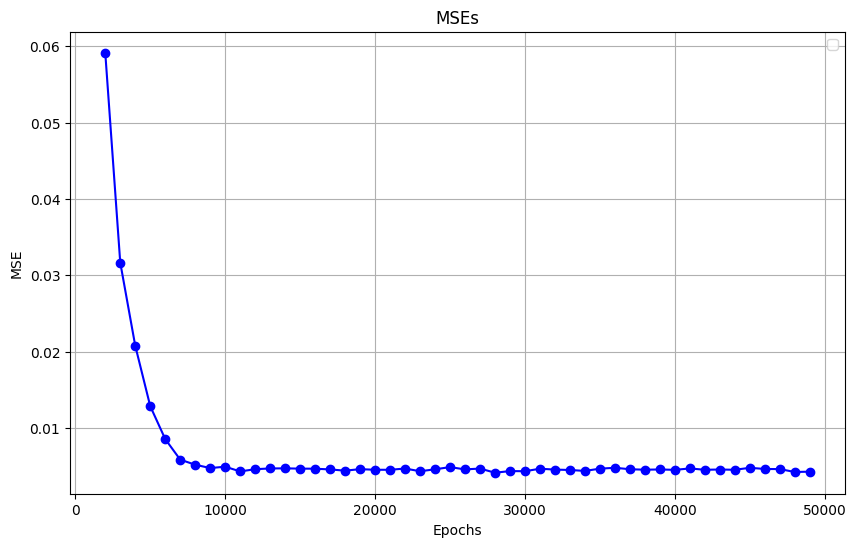

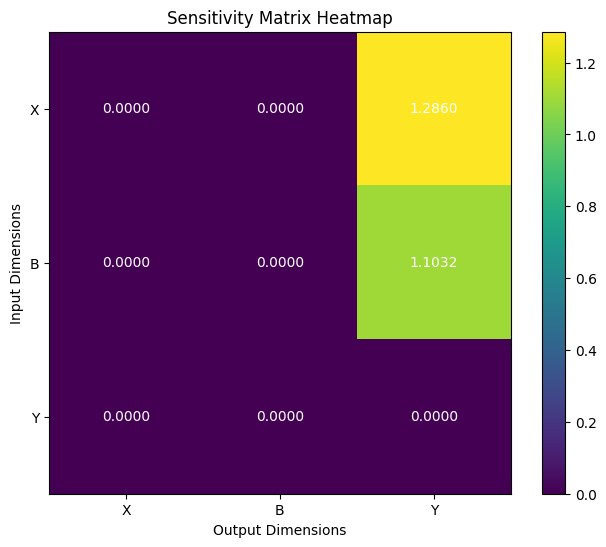

ATE: [0.3] est ATE: 0.3242046293914318
4.600000000000001
step 0 of 50000: train_loss 2.0236, val loss 2.0412
step 1000 of 50000: train_loss 0.1174, val loss 0.1187
step 2000 of 50000: train_loss 0.0071, val loss 0.0071
step 3000 of 50000: train_loss 0.0052, val loss 0.0053
step 4000 of 50000: train_loss 0.0048, val loss 0.0048
step 5000 of 50000: train_loss 0.0048, val loss 0.0046
step 6000 of 50000: train_loss 0.0050, val loss 0.0046
step 7000 of 50000: train_loss 0.0047, val loss 0.0043
step 8000 of 50000: train_loss 0.0046, val loss 0.0044
step 9000 of 50000: train_loss 0.0041, val loss 0.0043
step 10000 of 50000: train_loss 0.0048, val loss 0.0043
step 11000 of 50000: train_loss 0.0044, val loss 0.0041
step 12000 of 50000: train_loss 0.0039, val loss 0.0041
step 13000 of 50000: train_loss 0.0043, val loss 0.0042
step 14000 of 50000: train_loss 0.0041, val loss 0.0041
step 15000 of 50000: train_loss 0.0041, val loss 0.0040
step 16000 of 50000: train_loss 0.0040, val loss 0.0038
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


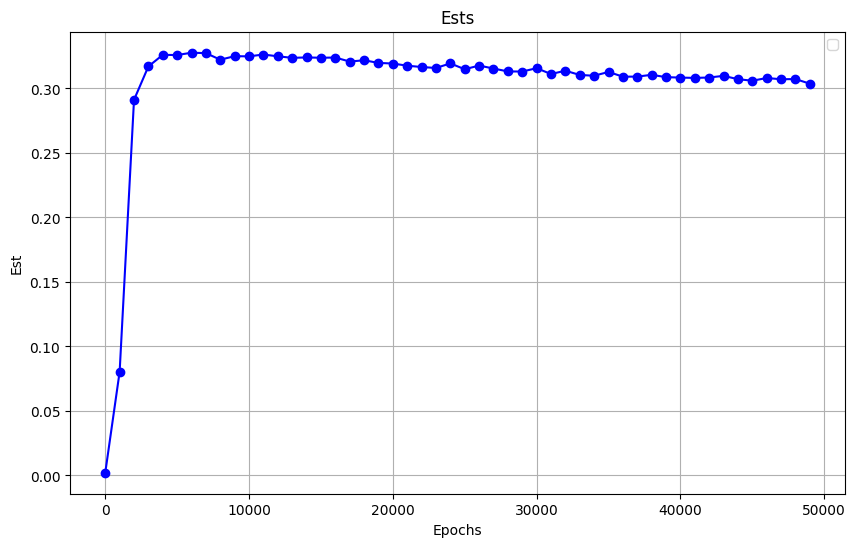

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


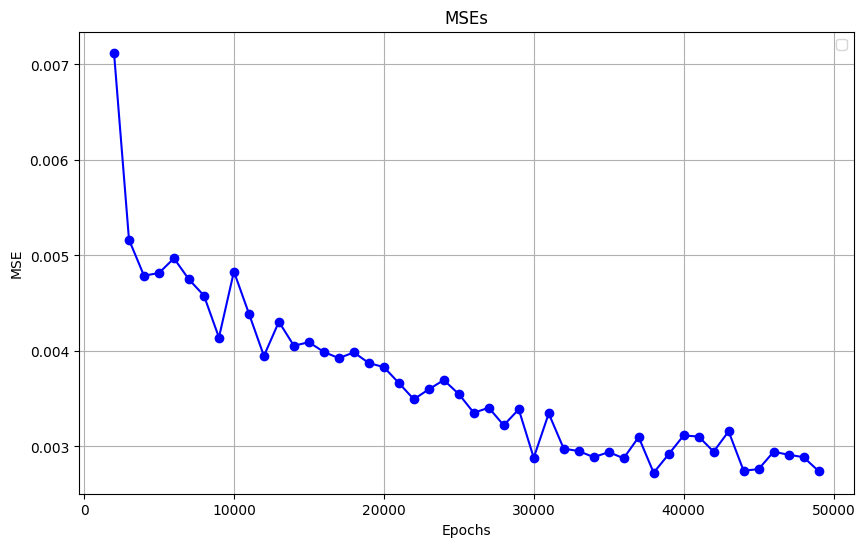

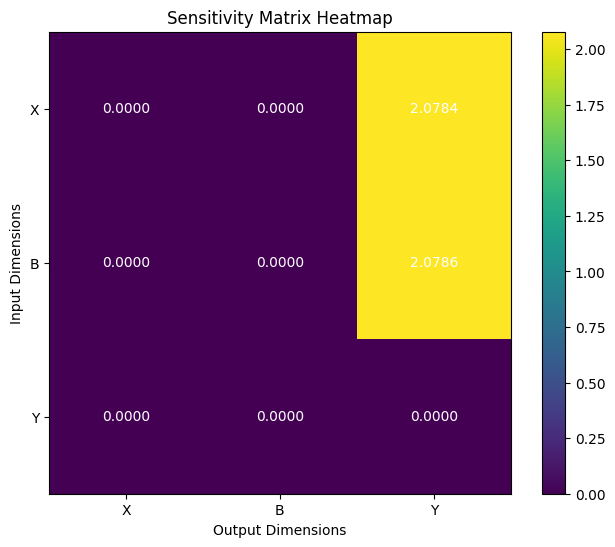

ATE: [0.3] est ATE: 0.309662766418457
4.800000000000002
step 0 of 50000: train_loss 2.6143, val loss 2.5982
step 1000 of 50000: train_loss 0.1773, val loss 0.1795
step 2000 of 50000: train_loss 0.1678, val loss 0.1707
step 3000 of 50000: train_loss 0.0040, val loss 0.0043
step 4000 of 50000: train_loss 0.0034, val loss 0.0039
step 5000 of 50000: train_loss 0.0033, val loss 0.0036
step 6000 of 50000: train_loss 0.0032, val loss 0.0036
step 7000 of 50000: train_loss 0.0033, val loss 0.0038
step 8000 of 50000: train_loss 0.0033, val loss 0.0033
step 9000 of 50000: train_loss 0.0032, val loss 0.0035
step 10000 of 50000: train_loss 0.0033, val loss 0.0034
step 11000 of 50000: train_loss 0.0031, val loss 0.0033
step 12000 of 50000: train_loss 0.0030, val loss 0.0033
step 13000 of 50000: train_loss 0.0029, val loss 0.0033
step 14000 of 50000: train_loss 0.0031, val loss 0.0033
step 15000 of 50000: train_loss 0.0029, val loss 0.0034
step 16000 of 50000: train_loss 0.0030, val loss 0.0032
step 

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


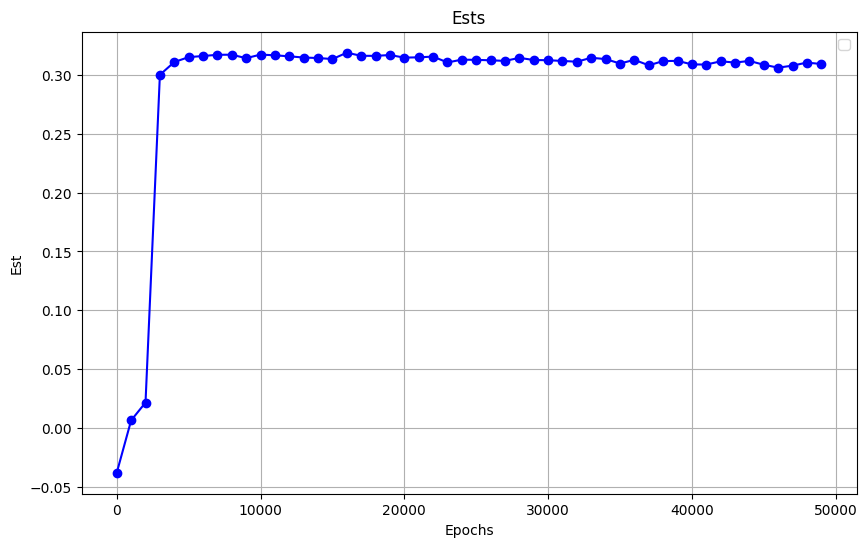

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


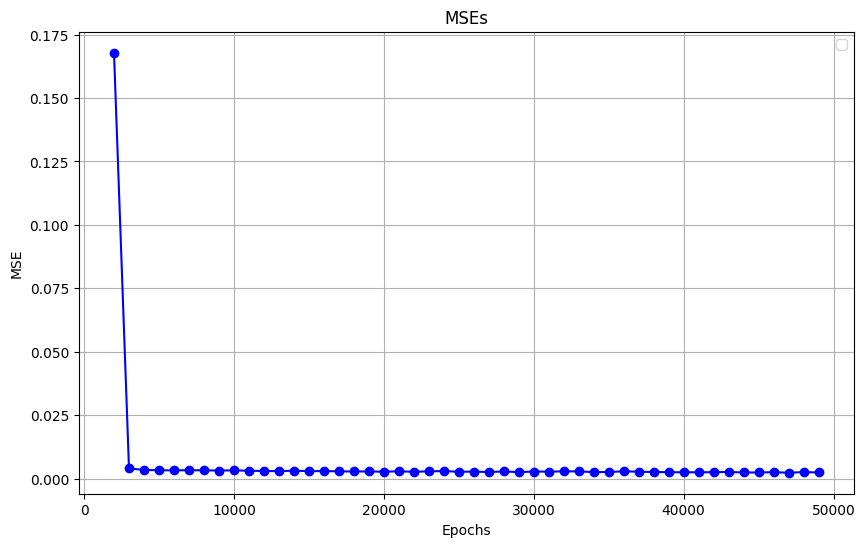

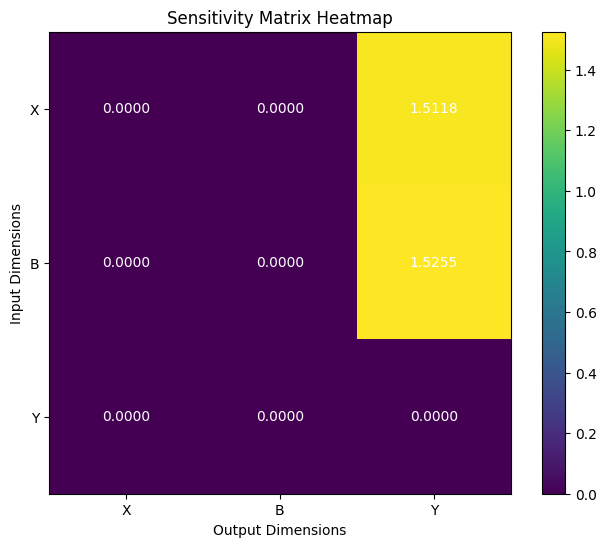

ATE: [0.3] est ATE: 0.3075399794185162
5.000000000000002
step 0 of 50000: train_loss 8.8478, val loss 8.8694
step 1000 of 50000: train_loss 0.1012, val loss 0.1033
step 2000 of 50000: train_loss 0.0867, val loss 0.0863
step 3000 of 50000: train_loss 0.0715, val loss 0.0699
step 4000 of 50000: train_loss 0.0494, val loss 0.0487
step 5000 of 50000: train_loss 0.0144, val loss 0.0146
step 6000 of 50000: train_loss 0.0103, val loss 0.0108
step 7000 of 50000: train_loss 0.0094, val loss 0.0099
step 8000 of 50000: train_loss 0.0087, val loss 0.0091
step 9000 of 50000: train_loss 0.0081, val loss 0.0085
step 10000 of 50000: train_loss 0.0077, val loss 0.0074
step 11000 of 50000: train_loss 0.0070, val loss 0.0070
step 12000 of 50000: train_loss 0.0067, val loss 0.0069
step 13000 of 50000: train_loss 0.0062, val loss 0.0064
step 14000 of 50000: train_loss 0.0058, val loss 0.0058
step 15000 of 50000: train_loss 0.0053, val loss 0.0052
step 16000 of 50000: train_loss 0.0047, val loss 0.0050
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


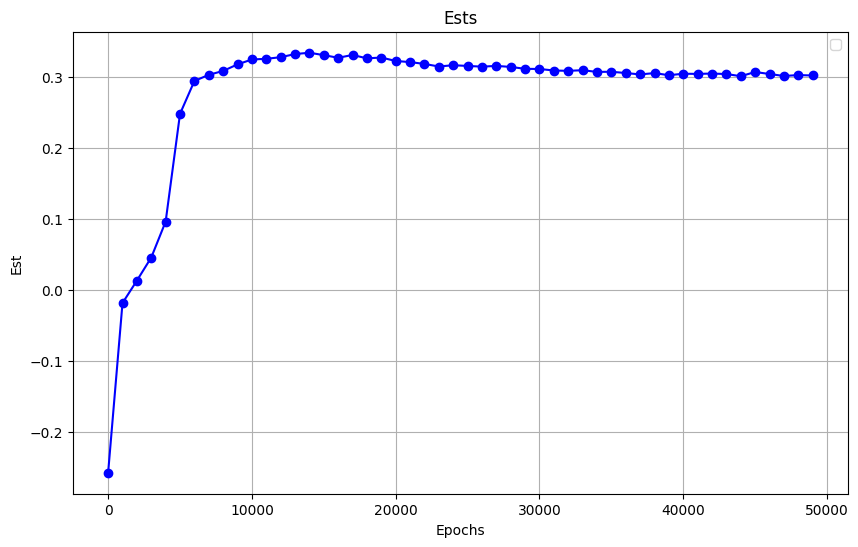

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


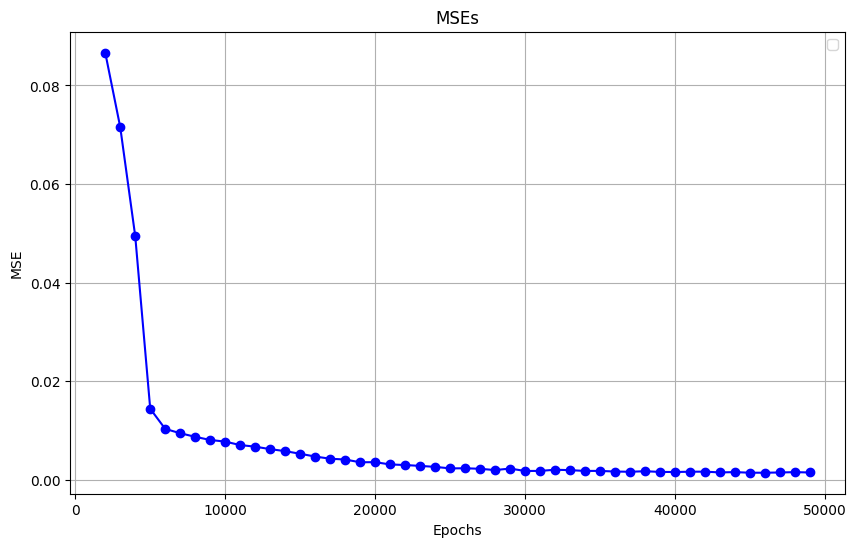

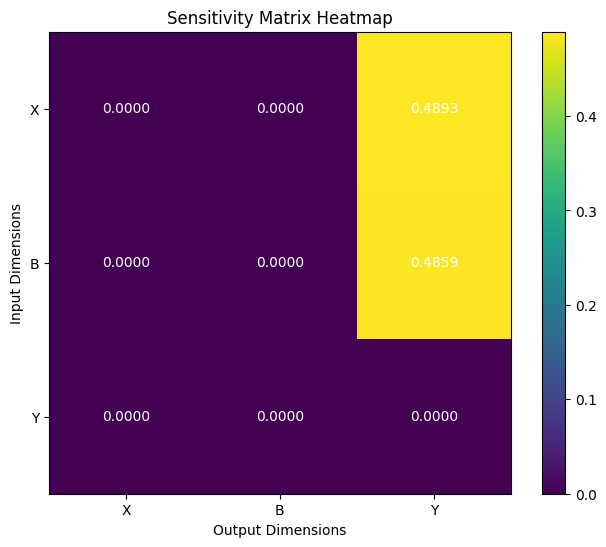

ATE: [0.3] est ATE: 0.30084985507011414
5.200000000000002
step 0 of 50000: train_loss 2.3220, val loss 2.3009
step 1000 of 50000: train_loss 0.1674, val loss 0.1665
step 2000 of 50000: train_loss 0.0373, val loss 0.0355
step 3000 of 50000: train_loss 0.0063, val loss 0.0061
step 4000 of 50000: train_loss 0.0040, val loss 0.0037
step 5000 of 50000: train_loss 0.0035, val loss 0.0032
step 6000 of 50000: train_loss 0.0031, val loss 0.0028
step 7000 of 50000: train_loss 0.0027, val loss 0.0023
step 8000 of 50000: train_loss 0.0024, val loss 0.0021
step 9000 of 50000: train_loss 0.0021, val loss 0.0018
step 10000 of 50000: train_loss 0.0020, val loss 0.0018
step 11000 of 50000: train_loss 0.0019, val loss 0.0017
step 12000 of 50000: train_loss 0.0017, val loss 0.0014
step 13000 of 50000: train_loss 0.0015, val loss 0.0013
step 14000 of 50000: train_loss 0.0016, val loss 0.0013
step 15000 of 50000: train_loss 0.0014, val loss 0.0012
step 16000 of 50000: train_loss 0.0014, val loss 0.0014
ste

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


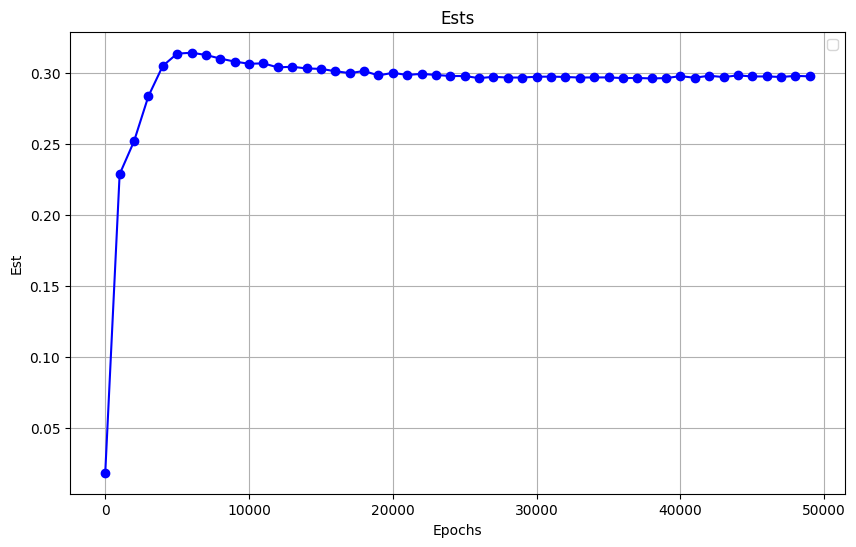

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


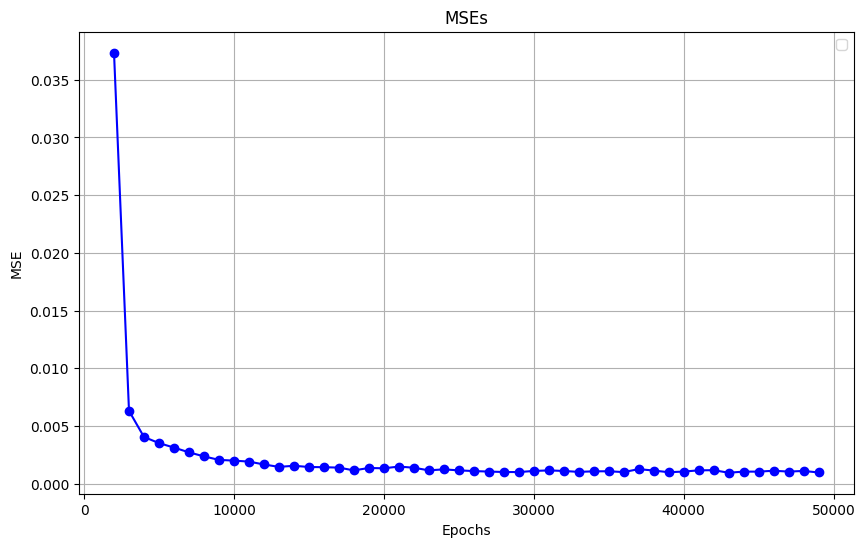

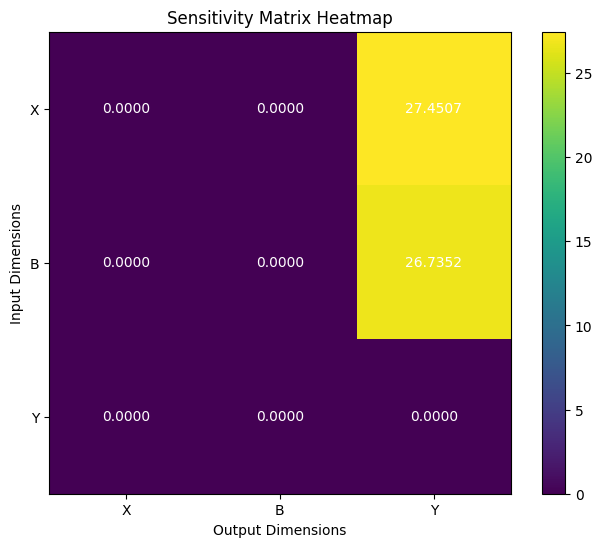

ATE: [0.3] est ATE: 0.2979573944634199
5.400000000000002
step 0 of 50000: train_loss 2.2801, val loss 2.2726
step 1000 of 50000: train_loss 0.0988, val loss 0.1024
step 2000 of 50000: train_loss 0.0834, val loss 0.0853
step 3000 of 50000: train_loss 0.0794, val loss 0.0804
step 4000 of 50000: train_loss 0.0797, val loss 0.0792
step 5000 of 50000: train_loss 0.0775, val loss 0.0796
step 6000 of 50000: train_loss 0.0770, val loss 0.0788
step 7000 of 50000: train_loss 0.0749, val loss 0.0761
step 8000 of 50000: train_loss 0.0705, val loss 0.0701
step 9000 of 50000: train_loss 0.0576, val loss 0.0586
step 10000 of 50000: train_loss 0.0424, val loss 0.0422
step 11000 of 50000: train_loss 0.0306, val loss 0.0294
step 12000 of 50000: train_loss 0.0240, val loss 0.0244
step 13000 of 50000: train_loss 0.0214, val loss 0.0218
step 14000 of 50000: train_loss 0.0196, val loss 0.0189
step 15000 of 50000: train_loss 0.0187, val loss 0.0186
step 16000 of 50000: train_loss 0.0183, val loss 0.0185
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


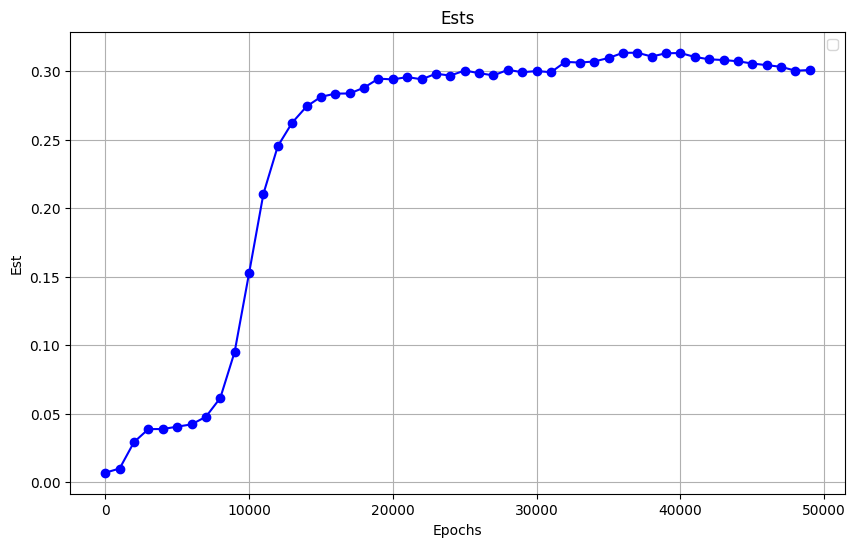

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


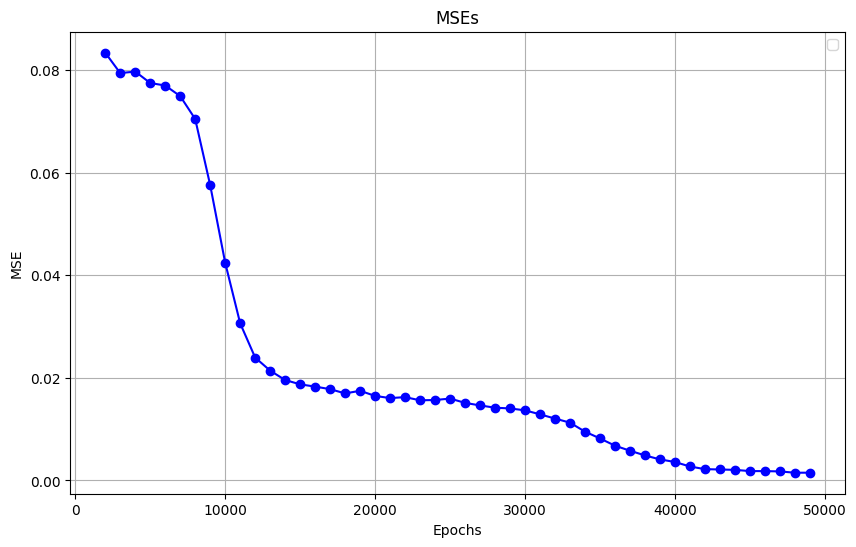

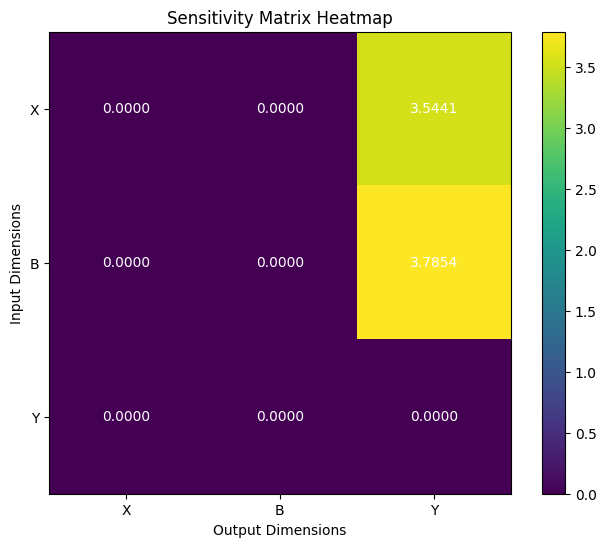

ATE: [0.3] est ATE: 0.2996838144659996
5.600000000000002
step 0 of 50000: train_loss 3.1651, val loss 3.1651
step 1000 of 50000: train_loss 0.0404, val loss 0.0391
step 2000 of 50000: train_loss 0.0133, val loss 0.0129
step 3000 of 50000: train_loss 0.0080, val loss 0.0079
step 4000 of 50000: train_loss 0.0064, val loss 0.0065
step 5000 of 50000: train_loss 0.0049, val loss 0.0047
step 6000 of 50000: train_loss 0.0034, val loss 0.0032
step 7000 of 50000: train_loss 0.0028, val loss 0.0025
step 8000 of 50000: train_loss 0.0019, val loss 0.0020
step 9000 of 50000: train_loss 0.0017, val loss 0.0017
step 10000 of 50000: train_loss 0.0016, val loss 0.0014
step 11000 of 50000: train_loss 0.0013, val loss 0.0011
step 12000 of 50000: train_loss 0.0012, val loss 0.0012
step 13000 of 50000: train_loss 0.0013, val loss 0.0011
step 14000 of 50000: train_loss 0.0012, val loss 0.0010
step 15000 of 50000: train_loss 0.0010, val loss 0.0011
step 16000 of 50000: train_loss 0.0010, val loss 0.0009
step

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


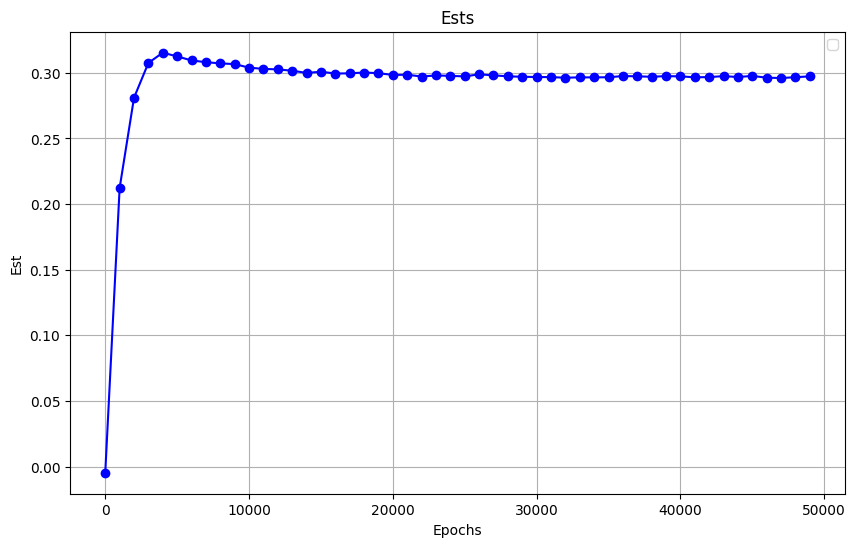

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


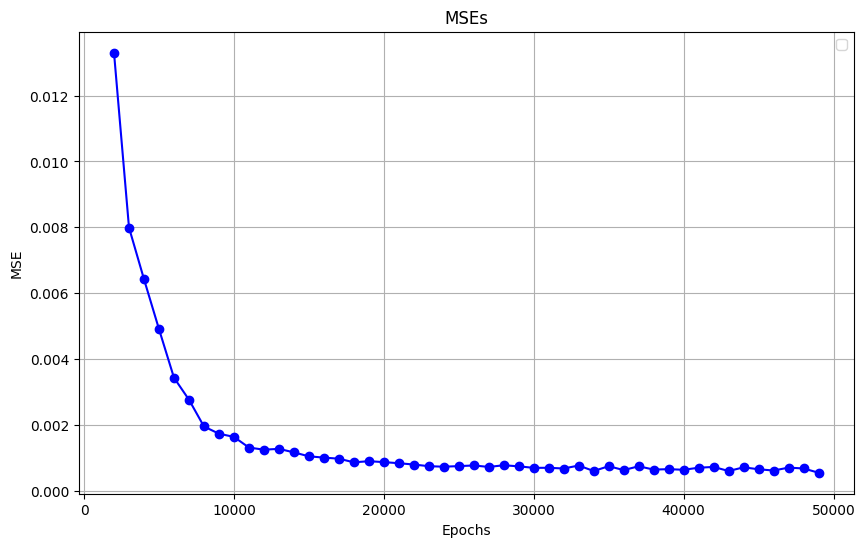

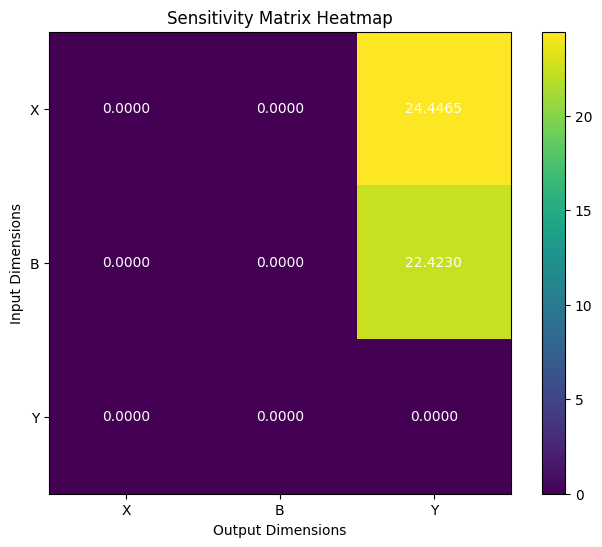

ATE: [0.3] est ATE: 0.29687215836167336
5.8000000000000025
step 0 of 50000: train_loss 3.1434, val loss 3.1289
step 1000 of 50000: train_loss 0.0592, val loss 0.0569
step 2000 of 50000: train_loss 0.0134, val loss 0.0127
step 3000 of 50000: train_loss 0.0059, val loss 0.0059
step 4000 of 50000: train_loss 0.0045, val loss 0.0046
step 5000 of 50000: train_loss 0.0036, val loss 0.0037
step 6000 of 50000: train_loss 0.0033, val loss 0.0032
step 7000 of 50000: train_loss 0.0028, val loss 0.0031
step 8000 of 50000: train_loss 0.0027, val loss 0.0027
step 9000 of 50000: train_loss 0.0026, val loss 0.0027
step 10000 of 50000: train_loss 0.0025, val loss 0.0025
step 11000 of 50000: train_loss 0.0025, val loss 0.0025
step 12000 of 50000: train_loss 0.0023, val loss 0.0022
step 13000 of 50000: train_loss 0.0023, val loss 0.0022
step 14000 of 50000: train_loss 0.0022, val loss 0.0022
step 15000 of 50000: train_loss 0.0022, val loss 0.0021
step 16000 of 50000: train_loss 0.0021, val loss 0.0020
st

/tmp/ipykernel_200854/1619389997.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


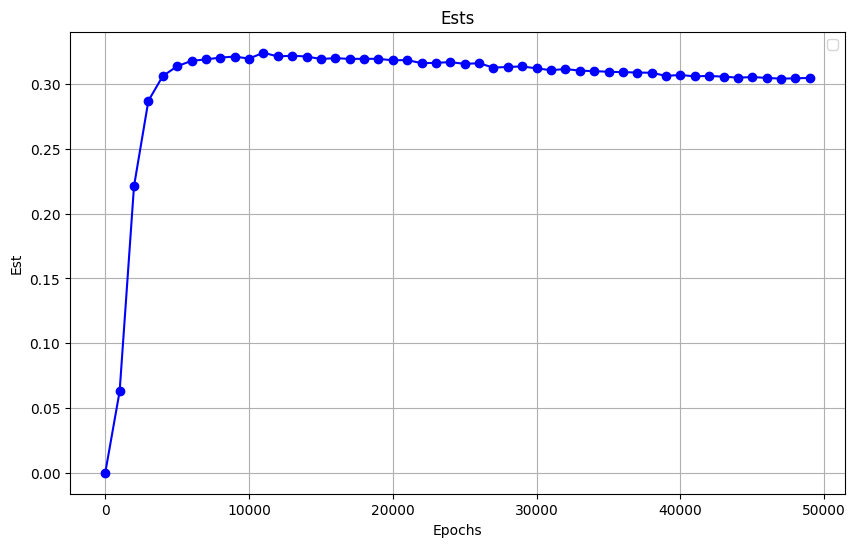

/tmp/ipykernel_200854/1619389997.py:107: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


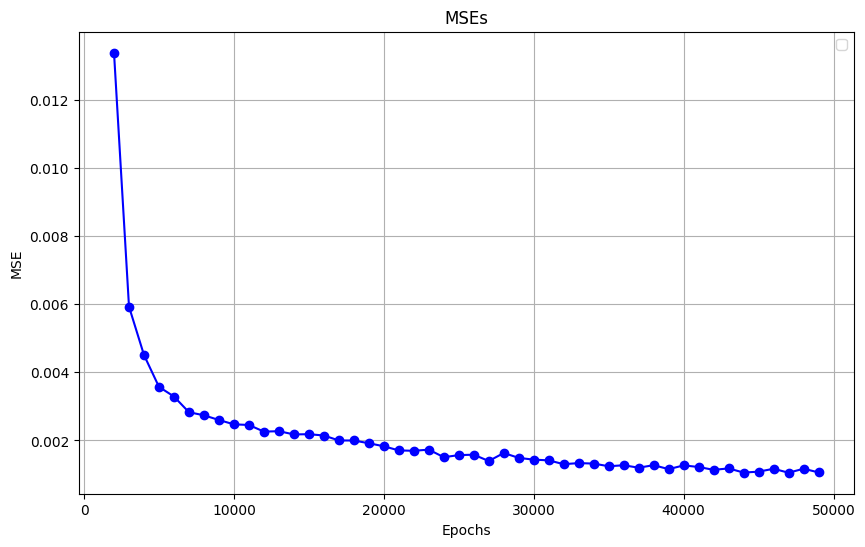

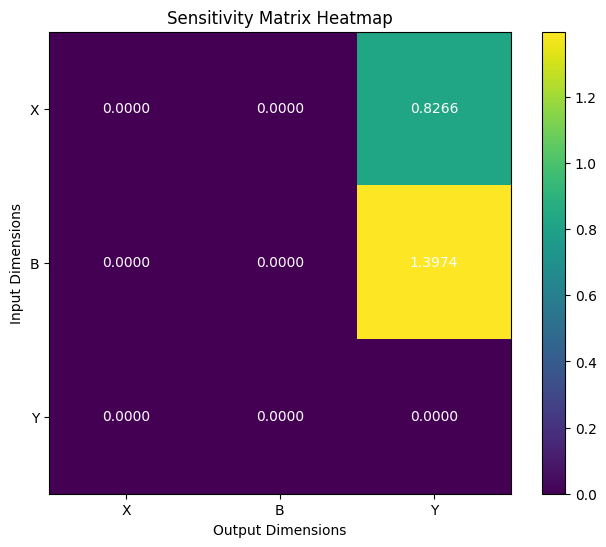

ATE: [0.3] est ATE: 0.30333741864442826
6.000000000000003
[-4.6251000557094814e-06, 0.0410725240598293, 0.08143004749912769, 0.1330797272871621, 0.1853175171256624, 0.2368140658453852, 0.29177643870413306, 0.3209540107204765, 0.34835662363737824, 0.3716143916773796, 0.3736764186003804, 0.3466193006595969, 0.35557446001678705, 0.33474787387251853, 0.2932986759328842, 0.3639128299966454, 0.32253952850878237, 0.3344797118371725, 0.3168758616936207, 0.3045302308881283, 0.2977015878653526, 0.31489393789768216, 0.3242046293914318, 0.309662766418457, 0.3075399794185162, 0.30084985507011414, 0.2979573944634199, 0.2996838144659996, 0.29687215836167336, 0.30333741864442826]


"Notes:\nactivation seems to play some role, but not be the main issue. Mish, Swish, and LeakyReLU have been tested and work, but conditional on the shift issue (see below).\nshifting y seems not to have an impact, but shifting x does. It impacts the loss, and the estimation of the causal effect. \nIf X and B are both shifted by the same amount, the network fails. However, if X is shifted away from zero and B is not, it works.\nImportantly, bypassing the attention mechanism (and feeding Vprime only as the output of the MHA head doesn't work either!).\n"

In [25]:

_, _, _, _, _, Y0, Y1 = generate_data(N=1000000, d=d)
ATE = (Y1 - Y0).mean(0)  # multi-dim ATE based off a large sample

print('ATE:', ATE)

estimates = []
x_shifts = []
x_inc = 0.2
for i in range(30):
    x_shifts.append(x_shift)
    
    all_data, DAGnx, var_names, causal_ordering, var_types, Y0, Y1 = generate_data(N=sample_size, x_shift=x_shift, d=d)
    
    
    indices = np.arange(0, len(all_data))
    np.random.shuffle(indices)
    
    val_inds = indices[:int(validation_fraction*len(indices))]
    train_inds = indices[int(validation_fraction*len(indices)):]
    
    train_data = all_data[train_inds]
    val_data = all_data[val_inds]
    
    train_data, val_data = torch.from_numpy(train_data).float(),  torch.from_numpy(val_data).float()
    input_dim = all_data.shape[2]
    
    model = CaT(input_dim=input_dim,
                    dropout_rate=dropout_rate,
                    head_size=head_size,
                    num_heads=num_heads,
                    ff_n_embed=ff_n_embed,
                    dag=DAGnx,
                    causal_ordering=causal_ordering,
                    n_layers=n_layers,
                    device=device,
                    var_types=var_types, activation_function='Swish'
                    ).to(device)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    all_var_losses = {}
    inter_model_ests = []
    sub_epoch = []
    mses = [] 
    for iter_ in range(0, max_iters):
        # train and update the model
        model.train()
    
        xb = get_batch(train_data=train_data, val_data=val_data, split='train', device=device, batch_size=batch_size)
        xb_mod = torch.clone(xb.detach())
        X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=shuffling)
    
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
    
    
        if iter_ % eval_interval == 0:  # evaluate the loss (no gradients)
            for key in loss_dict.keys():
                if key not in all_var_losses.keys():
                    all_var_losses[key] = []
                all_var_losses[key].append(loss_dict[key])
    
            model.eval()
            eval_loss = {}
            for split in ['train', 'val']:
                losses = torch.zeros(eval_iters)
                for k in range(eval_iters):
    
                    xb = get_batch(train_data=train_data, val_data=val_data, split=split, device=device,
                                   batch_size=batch_size)
                    xb_mod = torch.clone(xb.detach())
                    X, loss, loss_dict = model(X=xb, targets=xb_mod, shuffling=False)
                    losses[k] = loss.item()
                eval_loss[split] = losses.mean()
            mses.append(eval_loss['train'])
                
            intervention_nodes_vals_0 = {'X':  x_shift + 0}
            intervention_nodes_vals_1 = {'X':  x_shift + 1}
            ci = inference.CausalInference(model=model, device=device)
            D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
            D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
            
            effect_var = 'Y'
            effect_index = utils.find_element_in_list(var_names, target_string=effect_var)
            
            est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
            inter_model_ests.append(est_ATE)
            sub_epoch.append(iter_)
            model.train()
            print(f"step {iter_} of {max_iters}: train_loss {eval_loss['train']:.4f}, val loss {eval_loss['val']:.4f}")

    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch, inter_model_ests, marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('Est')
    plt.title('Ests')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(sub_epoch[2:], mses[2:], marker='o', linestyle='-', color='b')
    plt.xlabel('Epochs')
    plt.ylabel('MSE')
    plt.title('MSEs')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    sensitivity_matrix = input_output_sensitivity_matrix(xb[0:1], model, full=True).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    plt.imshow(sensitivity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar()
    
    for i in range(sensitivity_matrix.shape[0]):
        for j in range(sensitivity_matrix.shape[1]):
            plt.text(j, i, f'{sensitivity_matrix[i, j]:.4f}', ha='center', va='center', color='white')
    
    plt.xlabel('Output Dimensions')
    plt.ylabel('Input Dimensions')
    plt.title('Sensitivity Matrix Heatmap')
    plt.xticks(ticks=np.arange(len(var_names)), labels=var_names)
    plt.yticks(ticks=np.arange(len(var_names)), labels=var_names)
    # Display the plot
    plt.show()
    
    
    model.eval()
    intervention_nodes_vals_0 = {'X':  x_shift + 0}
    intervention_nodes_vals_1 = {'X':  x_shift + 1}
    ci = inference.CausalInference(model=model, device=device)
    D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
    D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)
    
    
    effect_var = 'Y'
    effect_index = utils.find_element_in_list(var_names, target_string=effect_var)
    
    est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean()
    print('ATE:', ATE, 'est ATE:', est_ATE)
    estimates.append(est_ATE)
    
    x_shift += x_inc
    print(x_shift)
    
print(estimates)

'''Notes:
activation seems to play some role, but not be the main issue. Mish, Swish, and LeakyReLU have been tested and work, but conditional on the shift issue (see below).
shifting y seems not to have an impact, but shifting x does. It impacts the loss, and the estimation of the causal effect. 
If X and B are both shifted by the same amount, the network fails. However, if X is shifted away from zero and B is not, it works.
Importantly, bypassing the attention mechanism (and feeding Vprime only as the output of the MHA head doesn't work either!).
'''

In [ ]:
model.eval()
intervention_nodes_vals_0 = {'X': x_shift + 0}
intervention_nodes_vals_1 = {'X': x_shift + 1}
ci = inference.CausalInference(model=model, device=device)
D0 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_0)
D1 = ci.forward(data=all_data , intervention_nodes_vals=intervention_nodes_vals_1)

est_ATE = (D1[:,effect_index] - D0[:,effect_index]).mean(0)
print('ATE:', ATE, 'Full est ATE:', est_ATE)
preds = model(train_data.to(device))

train_data0 = train_data.clone()
train_data1 = train_data.clone()

train_data0[:, 0] =  x_shift + 0
train_data1[:, 0] =  x_shift + 1
preds0 = model(train_data0.to(device))
preds1 = model(train_data1.to(device))
est_train_ATE = (preds1[:,effect_index] - preds0[:,effect_index]).mean(0)
print('ATE:', ATE, 'TRAIN est ATE:', est_train_ATE)

print('train y min and max:', train_data[:,effect_index,-1].min(), train_data[:,effect_index,-1].max())
print('pred y min and max:', preds[:,effect_index,-1].min(), preds[:,effect_index,-1].max())
print('train x vs train y')
plt.scatter(train_data[:,0,-1].detach().cpu().numpy(), train_data[:, effect_index, -1].detach().cpu().numpy())
plt.xlabel('train x')
plt.ylabel('train y')
plt.grid()
plt.show()

print('train y vs pred y')
plt.scatter(train_data[:,effect_index,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())

plt.xlabel('train y')
plt.ylabel('pred y')
plt.grid()
plt.show()

print('train x vs pred y')
plt.scatter(train_data[:,0,-1].detach().cpu().numpy(), preds[:, effect_index, -1].detach().cpu().numpy())
plt.xlabel('train x')
plt.ylabel('pred y')
plt.grid()
plt.show()


print('intervention preds')
plt.scatter(np.concatenate((np.zeros_like(preds0.detach().cpu().numpy()), np.ones_like(preds1.detach().cpu().numpy())), axis=0),  np.concatenate(((preds0.detach().cpu().numpy()), (preds1.detach().cpu().numpy())), axis=0))
mean_preds0 = preds0[:, effect_index, 0].mean().detach().cpu().numpy()
mean_preds1 = preds1[:, effect_index, 0].mean().detach().cpu().numpy()
plt.axhline(y=mean_preds0, color='r', linestyle='--', label=f'Mean do(x=0): {mean_preds0:.2f}')
plt.axhline(y=mean_preds1, color='b', linestyle='--', label=f'Mean do(x=1): {mean_preds1:.2f}')
plt.text(1.1, mean_preds0, f'{mean_preds0:.2f}', color='r', verticalalignment='center')
plt.text(1.1, mean_preds1, f'{mean_preds1:.2f}', color='b', verticalalignment='center')
plt.xlabel('do(x=0) do(x=1)')
plt.ylabel('pred y|do(x=1,x-0)')
plt.grid()
plt.show()


# Define the range of values from 0 to 1 in increments of 0.05
values = np.arange(x_shift + 0,  x_shift + 1.2, 0.05)
means = []

# Iterate over each value, set it in the dataset, and collect the model output
for val in values:
    train_data_clone = train_data.clone()  # Clone original data if needed to avoid modifying it
    train_data_clone[:, 0] = val
    
    preds = model(train_data_clone.to(device))
    
    mean_value = preds[:, effect_index, 0].mean().item()
    means.append(mean_value)


slope, intercept = np.polyfit(values, means, 1)


plt.figure(figsize=(8, 6))
plt.plot(values, means, marker='o', label='Data')
plt.plot(values, slope * values + intercept, label=f'Fit: Slope = {slope:.4f}', color='red')
plt.title('Mean of Model Output vs Input Value')
plt.xlabel('Input Value')
plt.ylabel('Mean of Output')
plt.legend()
plt.grid(True)
plt.show()

# Print the slope
print(f"Slope of the line: {slope:.4f}")

In [21]:
x_shifts

[5.0,
 5.2,
 5.4,
 5.6000000000000005,
 5.800000000000001,
 6.000000000000001,
 6.200000000000001,
 6.400000000000001,
 6.600000000000001,
 6.800000000000002,
 7.000000000000002,
 7.200000000000002,
 7.400000000000002,
 7.600000000000002,
 7.8000000000000025,
 8.000000000000002,
 8.200000000000001,
 8.4,
 8.6,
 8.799999999999999,
 8.999999999999998,
 9.199999999999998,
 9.399999999999997,
 9.599999999999996,
 9.799999999999995,
 9.999999999999995,
 10.199999999999994,
 10.399999999999993,
 10.599999999999993,
 10.799999999999992]

In [ ]:
plt.scatter(train_data[:,1,:].detach().cpu().numpy(), train_data[:,2,:].detach().cpu().numpy())
plt.xlim(0, 8)
plt.show()

plt.scatter(train_data[:, 0, :].detach().cpu().numpy(), train_data[:, 2, :].detach().cpu().numpy())
plt.xlim(0, 8)
plt.show()